<a href="https://colab.research.google.com/github/Bertaalcolea/Collagen_studies/blob/main/Ionic(25-11vs5-12).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Collgen_NaCl_KCl_Study1 (1).xlsx to Collgen_NaCl_KCl_Study1 (1).xlsx
Saving Collgen_NaCl_KCl_Study2.xlsx to Collgen_NaCl_KCl_Study2.xlsx
Archivo 25-11: Collgen_NaCl_KCl_Study1 (1).xlsx
Archivo 5-12 : Collgen_NaCl_KCl_Study2.xlsx
Resumen condiciones unificadas:
      study  species  salt        conc      pH_group                     cond
4734   5-12   Bovine   KCl      137 mM          pH 6       Bov KCl 137 mM pH6
18    25-11   Bovine   KCl      137 mM  unaltered/NA        Bovine KCl 137 mM
24    25-11   Bovine   KCl      200 mM  unaltered/NA        Bovine KCl 200 mM
4728   5-12   Bovine   KCl      200 mM  unaltered/NA           Bov KCl 200 mM
30    25-11   Bovine   KCl  Commercial  unaltered/NA    Bovine KCl Commercial
4722   5-12   Bovine   KCl  Commercial  unaltered/NA       Bov KCl commercial
4752   5-12      Rat   KCl      137 mM          pH 6       Rat KCl 137 mM pH6
0     25-11      Rat   KCl      137 mM  unaltered/NA           Rat KCl 137 mM
6     25-11      Rat   KCl    

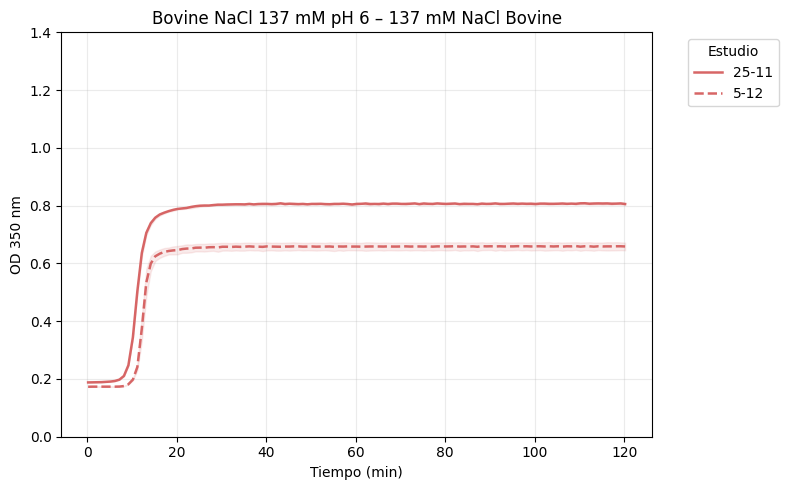

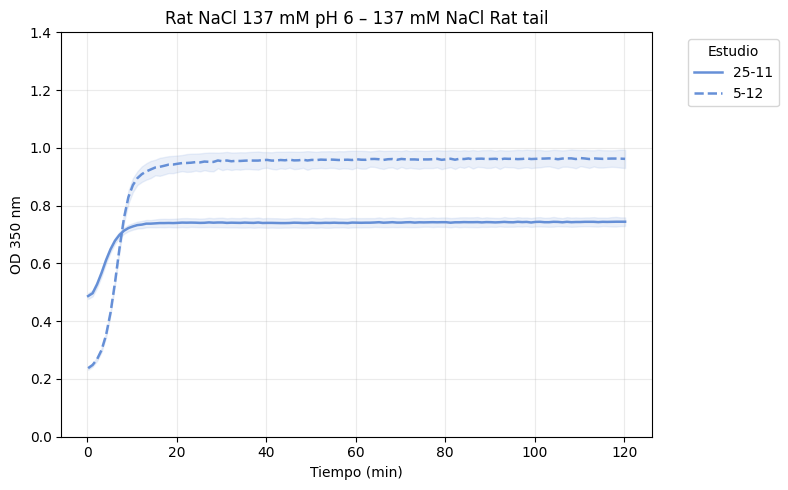

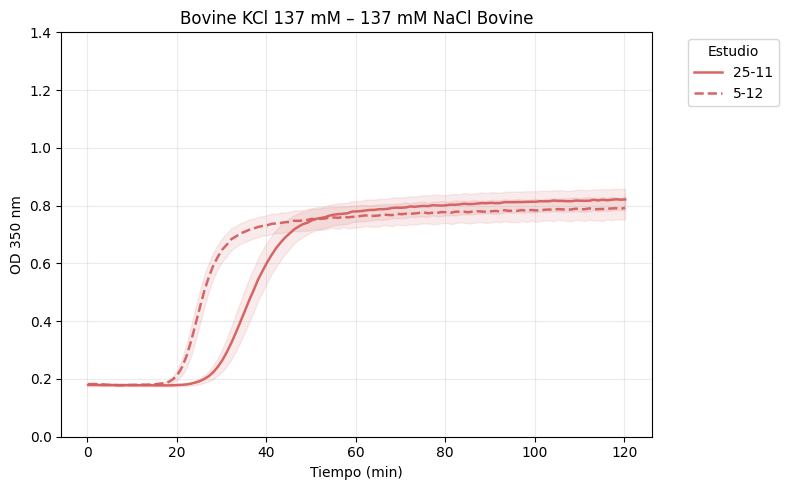

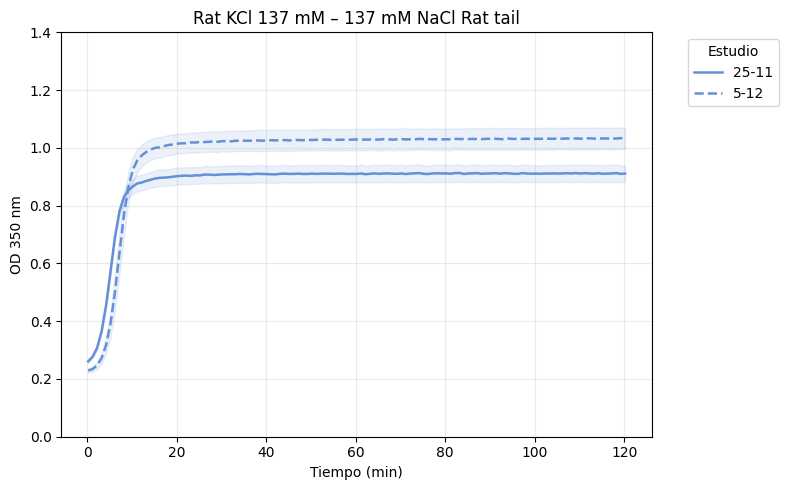

In [1]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ====== localizar archivos de cada estudio ======
filenames = list(uploaded.keys())

file_25_11 = [f for f in filenames if "Study1" in f or "25" in f][0]
file_5_12  = [f for f in filenames if "Study2" in f or "5-12" in f or "05" in f][0]

print("Archivo 25-11:", file_25_11)
print("Archivo 5-12 :", file_5_12)

# =========================================================
# FUNCIONES DE PARSEO COMUNES
# =========================================================

def parse_study1(filepath):
    """Tu parser del 25-11, adaptado a función."""
    raw = pd.read_excel(filepath, header=None)

    records = []
    time_rows = raw.index[
        raw[0].astype(str).str.startswith("350 - Time", na=False)
    ].tolist()

    for t_idx in time_rows:
        # tiempo en minutos
        time_str = str(raw.iloc[t_idx, 0])
        m = re.search(r"\((\d+):(\d+):(\d+)\)", time_str)
        if m:
            h, mm, ss = map(int, m.groups())
            time_min = h*60 + mm + ss/60
        else:
            time_min = np.nan

        # fila cabecera 1–12
        header_row = None
        for r in range(t_idx+1, min(t_idx+20, len(raw))):
            vals = raw.iloc[r].tolist()
            nums = []
            for v in vals:
                if isinstance(v, (int, float)) and not pd.isna(v):
                    nums.append(int(v))
                elif isinstance(v, str) and v.isdigit():
                    nums.append(int(v))
            if set(range(1, 13)).issubset(set(nums)):
                header_row = r
                break
        if header_row is None:
            continue

        header = raw.iloc[header_row]

        # columnas con 1–12
        well_cols = []
        for j, v in enumerate(header):
            if isinstance(v, (int, float)) and not pd.isna(v) and int(v) in range(1, 13):
                well_cols.append(j)
            elif isinstance(v, str) and v.isdigit() and int(v) in range(1, 13):
                well_cols.append(j)

        # filas A–H
        for offset in range(1, 9):
            rr = header_row + offset
            if rr >= len(raw):
                break
            row_label = raw.iloc[rr, 1]
            if row_label not in list("ABCDEFGH"):
                continue

            for j in well_cols:
                col_num = int(raw.iloc[header_row, j])
                od = raw.iloc[rr, j]
                if pd.isna(od):
                    continue
                records.append({
                    "time_min": time_min,
                    "row": row_label,
                    "col": col_num,
                    "OD": float(od),
                })

    long_df = pd.DataFrame(records)
    if long_df.empty:
        raise ValueError("Study1: records vacío, algo pasa con el Excel.")

    long_df["well"] = long_df["row"] + long_df["col"].astype(str)

    # ---- assign_meta tal cual lo tenías ----
    def assign_meta(row):
        r = row["row"]
        c = row["col"]

        species   = None
        salt      = None
        conc      = None
        pH_group  = "unaltered/NA"
        cond      = None

        # CONTROL (sin sal) – G1, G2, G3
        if r == "G" and c in [1, 2, 3]:
            species  = "Control"
            salt     = "None"
            conc     = None
            pH_group = "unaltered/NA"
            cond     = "Control (no salt)"
            return pd.Series({
                "species":  species,
                "salt":     salt,
                "conc":     conc,
                "pH_group": pH_group,
                "cond":     cond
            })

        # KCl – RAT (A–C, col 1–3)
        if r == "A" and c in [1, 2, 3]:
            species  = "Rat"
            salt     = "KCl"
            conc     = "137 mM"
            cond     = "Rat KCl 137 mM"
        elif r == "B" and c in [1, 2, 3]:
            species  = "Rat"
            salt     = "KCl"
            conc     = "200 mM"
            cond     = "Rat KCl 200 mM"
        elif r == "C" and c in [1, 2, 3]:
            species  = "Rat"
            salt     = "KCl"
            conc     = "Commercial"
            cond     = "Rat KCl Commercial"

        # KCl – BOVINE (D–F, col 1–3)
        elif r == "D" and c in [1, 2, 3]:
            species  = "Bovine"
            salt     = "KCl"
            conc     = "137 mM"
            cond     = "Bovine KCl 137 mM"
        elif r == "E" and c in [1, 2, 3]:
            species  = "Bovine"
            salt     = "KCl"
            conc     = "200 mM"
            cond     = "Bovine KCl 200 mM"
        elif r == "F" and c in [1, 2, 3]:
            species  = "Bovine"
            salt     = "KCl"
            conc     = "Commercial"
            cond     = "Bovine KCl Commercial"

        # NaCl – RAT (A–C, col 7–9)
        elif r == "A" and c in [7, 8, 9]:
            species  = "Rat"
            salt     = "NaCl"
            conc     = "137 mM"
            pH_group = "pH 6"
            cond     = "Rat NaCl 137 mM pH 6"
        elif r == "B" and c in [7, 8, 9]:
            species  = "Rat"
            salt     = "NaCl"
            conc     = "200 mM"
            cond     = "Rat NaCl 200 mM"
        elif r == "C" and c in [7, 8, 9]:
            species  = "Rat"
            salt     = "NaCl"
            conc     = "Commercial"
            cond     = "Rat NaCl Commercial"

        # NaCl – BOVINE (D–F, col 7–9)
        elif r == "D" and c in [7, 8, 9]:
            species  = "Bovine"
            salt     = "NaCl"
            conc     = "137 mM"
            pH_group = "pH 6"
            cond     = "Bovine NaCl 137 mM pH 6"
        elif r == "E" and c in [7, 8, 9]:
            species  = "Bovine"
            salt     = "NaCl"
            conc     = "200 mM"
            cond     = "Bovine NaCl 200 mM"
        elif r == "F" and c in [7, 8, 9]:
            species  = "Bovine"
            salt     = "NaCl"
            conc     = "Commercial"
            cond     = "Bovine NaCl Commercial"

        return pd.Series({
            "species":  species,
            "salt":     salt,
            "conc":     conc,
            "pH_group": pH_group,
            "cond":     cond
        })

    meta = long_df.apply(assign_meta, axis=1)
    long_df = pd.concat([long_df, meta], axis=1)
    long_df = long_df[long_df["cond"].notna()].copy()
    long_df["study"] = "25-11"
    return long_df


def parse_study2(filepath):
    """Parser del 5-12, añadiendo species/salt/conc/pH_group coherentes con Study1."""
    raw = pd.read_excel(filepath, header=None)

    records = []
    time_rows = raw.index[
        raw[0].astype(str).str.startswith("350 - Time", na=False)
    ].tolist()

    for t_idx in time_rows:
        time_str = str(raw.iloc[t_idx, 0])
        m = re.search(r"\((\d+):(\d+):(\d+)\)", time_str)
        if m:
            h, mm, ss = map(int, m.groups())
            time_min = h*60 + mm + ss/60
        else:
            time_min = np.nan

        # fila cabecera 1–12
        header_row = None
        for r in range(t_idx+1, min(t_idx+20, len(raw))):
            vals = raw.iloc[r].tolist()
            nums = []
            for v in vals:
                if isinstance(v, (int, float)) and not pd.isna(v):
                    nums.append(int(v))
                elif isinstance(v, str) and v.isdigit():
                    nums.append(int(v))
            if set(range(1, 13)).issubset(set(nums)):
                header_row = r
                break
        if header_row is None:
            continue

        header = raw.iloc[header_row]

        # aquí usamos solo pozos 7–12, como en tu código
        well_cols = []
        for j, v in enumerate(header):
            if isinstance(v, (int, float)) and not pd.isna(v) and int(v) in range(7, 13):
                well_cols.append(j)
            elif isinstance(v, str) and v.isdigit() and int(v) in range(7, 13):
                well_cols.append(j)

        for offset in range(1, 9):
            rr = header_row + offset
            if rr >= len(raw):
                break
            row_label = raw.iloc[rr, 1]
            if row_label not in list("ABCDEFGH"):
                continue

            for j in well_cols:
                col_num = int(raw.iloc[header_row, j])
                od = raw.iloc[rr, j]
                if pd.isna(od):
                    continue
                records.append({
                    "time_min": time_min,
                    "row": row_label,
                    "col": col_num,
                    "OD": float(od),
                })

    long_df = pd.DataFrame(records)
    long_df["well"] = long_df["row"] + long_df["col"].astype(str)

    # ---- cond según tu classify_cond ----
    def classify_cond(row):
        r = row["row"]
        c = row["col"]

        # Control
        if r == "G" and c in [7, 8, 9]:
            return "Control (no salt)"

        # NaCl bovino
        if r == "A" and c in [7, 8, 9]:
            return "Bov NaCl commercial"
        if r == "B" and c in [7, 8, 9]:
            return "Bov NaCl 200 mM"
        if r == "C" and c in [7, 8, 9]:
            return "Bov NaCl 137 mM pH6"
        if r == "H" and c in [10, 11, 12]:
            return "Bov NaCl 137 mM pH7"

        # NaCl rata
        if r == "D" and c in [7, 8, 9]:
            return "Rat NaCl commercial"
        if r == "E" and c in [7, 8, 9]:
            return "Rat NaCl 200 mM"
        if r == "F" and c in [7, 8, 9]:
            return "Rat NaCl 137 mM pH6"
        if r == "G" and c in [10, 11, 12]:
            return "Rat NaCl 137 mM pH7"

        # KCl bovino
        if r == "A" and c in [10, 11, 12]:
            return "Bov KCl commercial"
        if r == "B" and c in [10, 11, 12]:
            return "Bov KCl 200 mM"
        if r == "C" and c in [10, 11, 12]:
            return "Bov KCl 137 mM pH6"

        # KCl rata
        if r == "D" and c in [10, 11, 12]:
            return "Rat KCl commercial"
        if r == "E" and c in [10, 11, 12]:
            return "Rat KCl 200 mM"
        if r == "F" and c in [10, 11, 12]:
            return "Rat KCl 137 mM pH6"

        return "Other"

    long_df["cond"] = long_df.apply(classify_cond, axis=1)

    # ---- meta coherente con Study1 ----
    def meta_from_cond(cond):
        species = None
        salt = None
        conc = None
        pH_group = "unaltered/NA"

        if cond == "Control (no salt)":
            species = "Control"
            salt = "None"
            conc = None
            return pd.Series({
                "species": species,
                "salt": salt,
                "conc": conc,
                "pH_group": pH_group
            })

        if cond.startswith("Bov"):
            species = "Bovine"
        elif cond.startswith("Rat"):
            species = "Rat"

        if "NaCl" in cond:
            salt = "NaCl"
        elif "KCl" in cond:
            salt = "KCl"

        if "137" in cond:
            conc = "137 mM"
        elif "200" in cond:
            conc = "200 mM"
        elif "commercial" in cond:
            conc = "Commercial"

        if "pH6" in cond or "pH 6" in cond:
            pH_group = "pH 6"
        elif "pH7" in cond or "pH 7" in cond:
            pH_group = "pH 7"

        return pd.Series({
            "species": species,
            "salt": salt,
            "conc": conc,
            "pH_group": pH_group
        })

    meta = long_df["cond"].apply(meta_from_cond)
    long_df = pd.concat([long_df, meta], axis=1)

    # quitamos pozos marcados como Other
    long_df = long_df[long_df["cond"] != "Other"].copy()
    long_df["study"] = "5-12"
    return long_df


# =========================================================
# APLICAR PARSERS Y UNIR
# =========================================================
df_25 = parse_study1(file_25_11)
df_5  = parse_study2(file_5_12)

all_df = pd.concat([df_25, df_5], ignore_index=True)

print("Resumen condiciones unificadas:")
print(
    all_df[["study","species","salt","conc","pH_group","cond"]]
    .drop_duplicates()
    .sort_values(["salt","species","conc","pH_group","study"])
)

# =========================================================
# COLORES Y FUNCIÓN DE COMPARACIÓN
# =========================================================

def get_color(species, pH_group):
    if species == "Bovine":
        base = "#d55e5e"    # rojo suave
        dark = "#7f0000"    # rojo oscuro
    elif species == "Rat":
        base = "#5e8ad5"    # azul suave
        dark = "#00007f"    # azul oscuro
    else:
        return "black"

    if "pH 7" in str(pH_group) or "pH7" in str(pH_group):
        return dark
    else:
        return base

def plot_study_comparison(df, species, salt, conc, pH_filter=None, title_suffix=""):
    sub = df[
        (df["species"] == species) &
        (df["salt"] == salt) &
        (df["conc"] == conc)
    ].copy()

    if pH_filter is not None:
        sub = sub[sub["pH_group"] == pH_filter].copy()

    if sub.empty:
        print("No hay datos para:", species, salt, conc, pH_filter)
        return

    # calcular mean + SE por estudio
    def sem(x):
        return x.std(ddof=1) / np.sqrt(len(x))

    stats = (
        sub
        .groupby(["time_min", "study"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
    )

    plt.figure(figsize=(8,5))
    # color por especie + pH
    color = get_color(species, pH_filter if pH_filter is not None else "unaltered/NA")

    for study_name, sub_st in stats.groupby("study"):
        sub_st = sub_st.sort_values("time_min")

        # estilo de línea por estudio
        if study_name == "25-11":
            ls = "-"
        else:
            ls = "--"

        label = f"{study_name}"

        # línea principal
        plt.plot(sub_st["time_min"], sub_st["mean"],
                 color=color, linestyle=ls,
                 linewidth=1.8, alpha=0.95,
                 label=label)

        # banda SE
        plt.fill_between(sub_st["time_min"],
                         sub_st["mean"] - sub_st["sem"],
                         sub_st["mean"] + sub_st["sem"],
                         color=color, alpha=0.12)

    title = f"{species} {salt} {conc}"
    if pH_filter is not None:
        title += f" {pH_filter}"
    if title_suffix:
        title += " – " + title_suffix

    plt.title(title)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(title="Estudio", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()


# =========================================================
# 4 GRÁFICAS PEDIDAS (usando 137 mM, pH 6 para NaCl)
# =========================================================

# 1) NaCl bovino 137 mM pH 6 – 25-11 vs 5-12
plot_study_comparison(
    all_df,
    species="Bovine",
    salt="NaCl",
    conc="137 mM",
    pH_filter="pH 6",
    title_suffix="137 mM NaCl Bovine"
)

# 2) NaCl rata 137 mM pH 6 – 25-11 vs 5-12
plot_study_comparison(
    all_df,
    species="Rat",
    salt="NaCl",
    conc="137 mM",
    pH_filter="pH 6",
    title_suffix="137 mM NaCl Rat tail"
)

# 3) KCl bovino 137 mM – 25-11 vs 5-12
plot_study_comparison(
    all_df,
    species="Bovine",
    salt="KCl",
    conc="137 mM",
    pH_filter=None,
    title_suffix="137 mM NaCl Bovine"
)

# 4) KCl rata 137 mM – 25-11 vs 5-12
plot_study_comparison(
    all_df,
    species="Rat",
    salt="KCl",
    conc="137 mM",
    pH_filter=None,
    title_suffix="137 mM NaCl Rat tail"
)


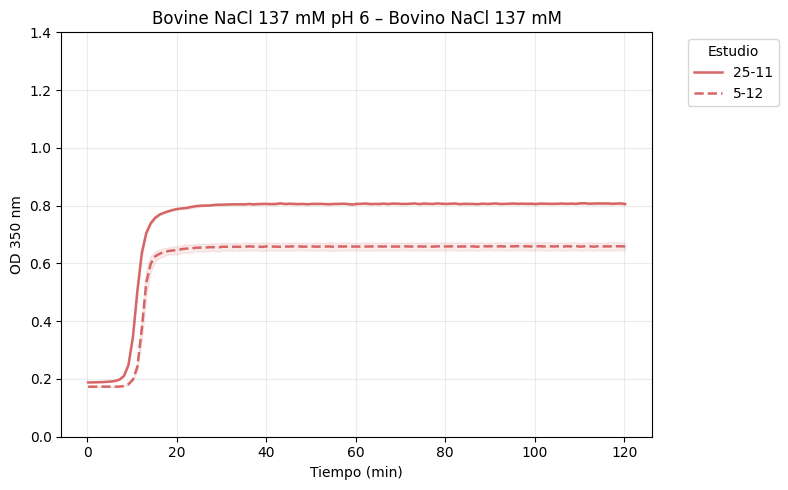

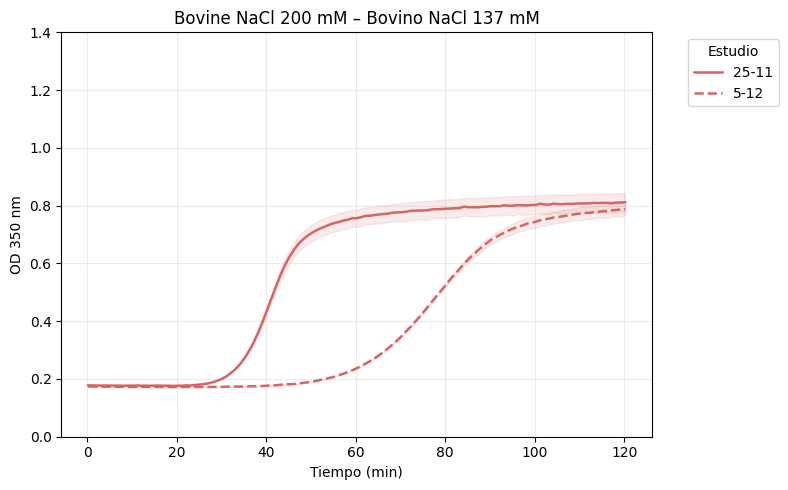

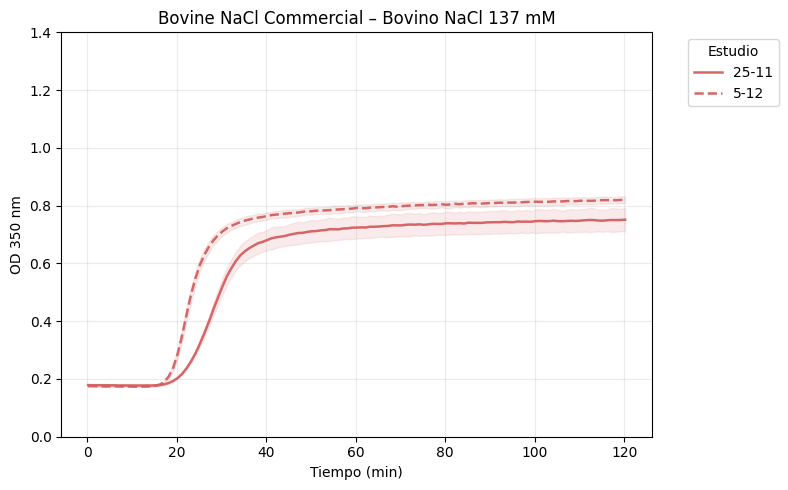

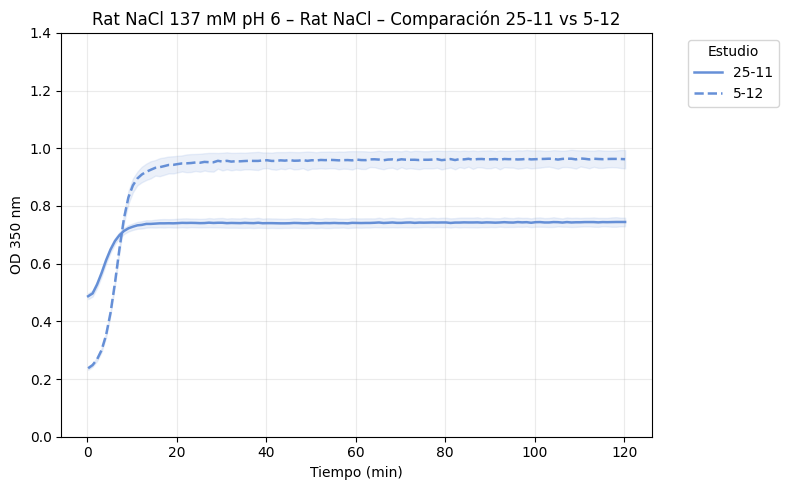

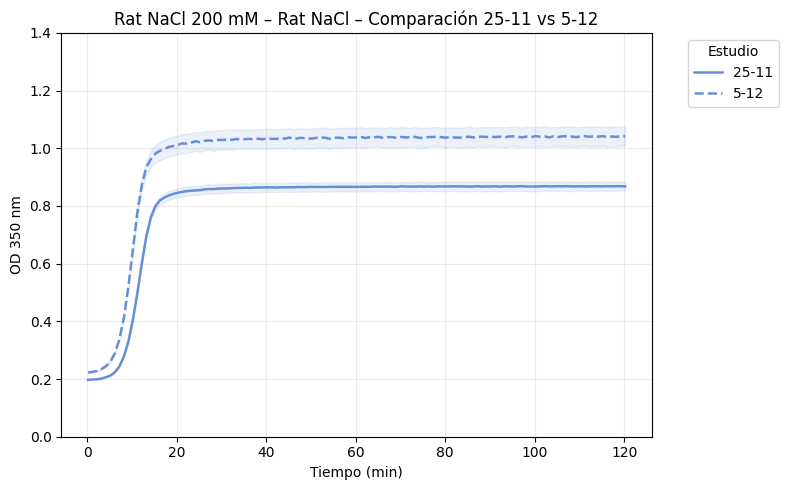

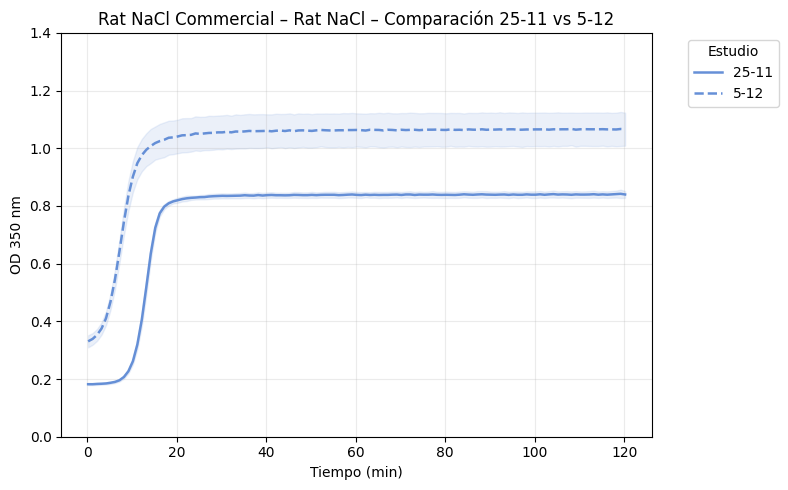

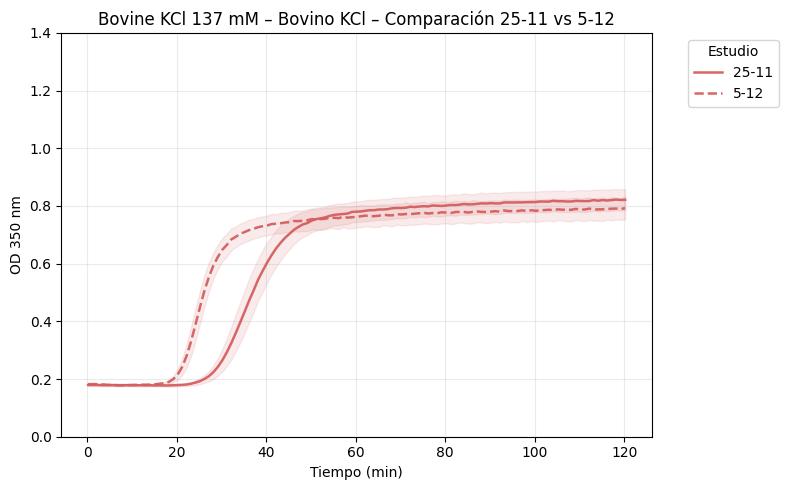

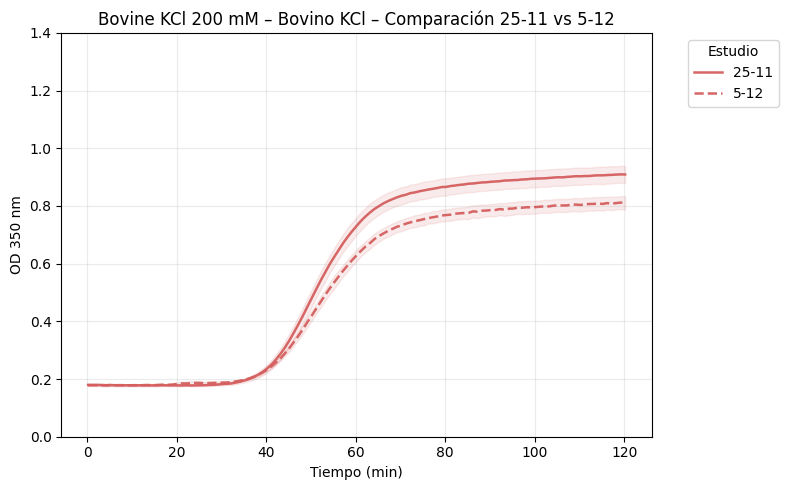

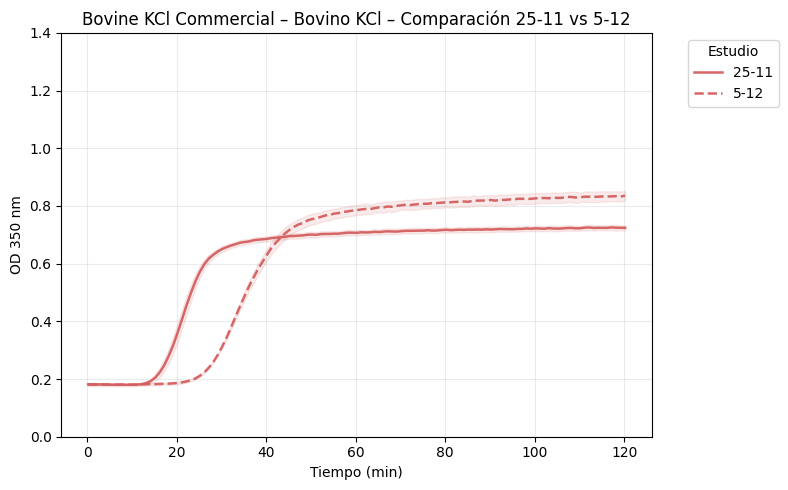

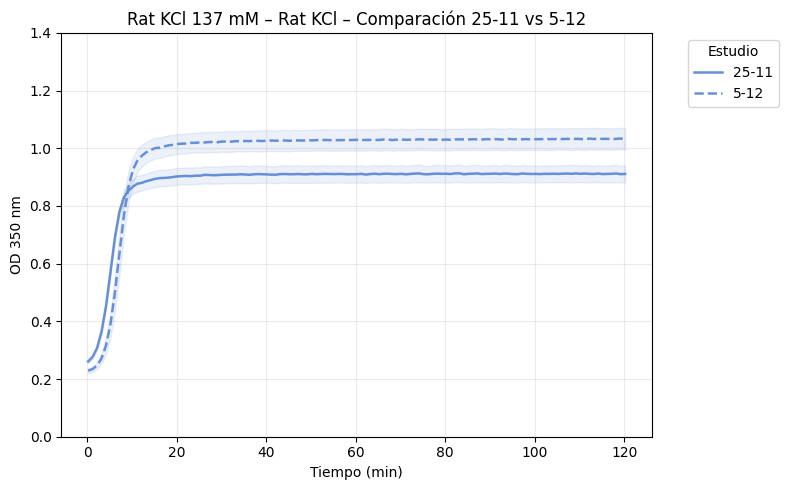

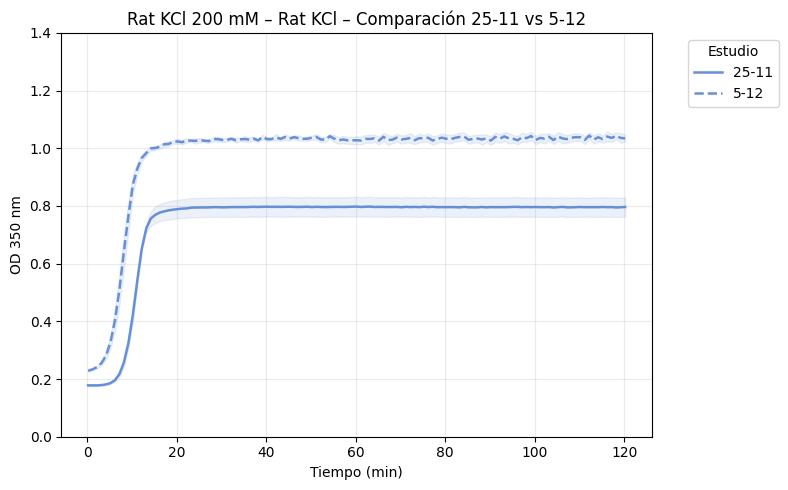

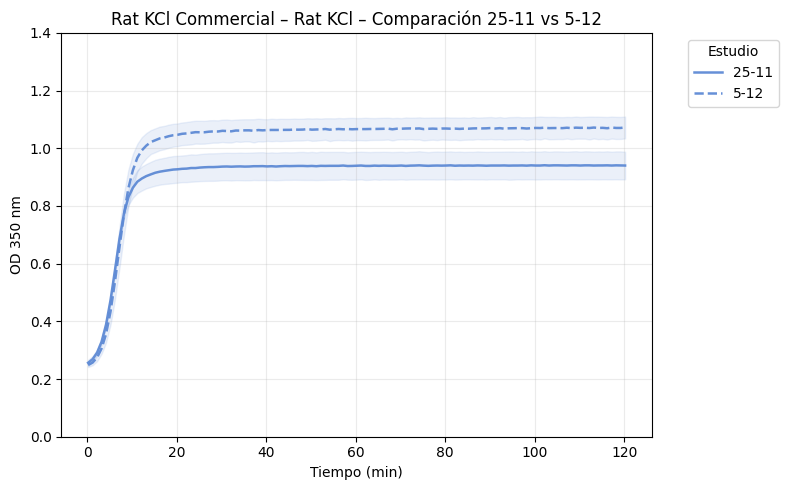

In [2]:
# ================================
# TODAS LAS CONCENTRACIONES
# ================================
# OJO: para 137 mM de NaCl, solo comparamos pH 6 (ignora pH 7 del día 5-12)

# --- NaCl BOVINO: 137 (pH 6), 200, Commercial ---
for conc in ["137 mM", "200 mM", "Commercial"]:
    pH = "pH 6" if conc == "137 mM" else None

    plot_study_comparison(
        all_df,
        species="Bovine",
        salt="NaCl",
        conc=conc,
        pH_filter=pH,
        title_suffix="Bovino NaCl 137 mM"
    )

# --- NaCl RATA: 137 (pH 6), 200, Commercial ---
for conc in ["137 mM", "200 mM", "Commercial"]:
    pH = "pH 6" if conc == "137 mM" else None

    plot_study_comparison(
        all_df,
        species="Rat",
        salt="NaCl",
        conc=conc,
        pH_filter=pH,
        title_suffix="Rat NaCl – Comparación 25-11 vs 5-12"
    )

# --- KCl BOVINO: 137, 200, Commercial ---
# (KCl solo tiene un "pH_group", así que no filtramos por pH)
for conc in ["137 mM", "200 mM", "Commercial"]:
    plot_study_comparison(
        all_df,
        species="Bovine",
        salt="KCl",
        conc=conc,
        pH_filter=None,
        title_suffix="Bovino KCl – Comparación 25-11 vs 5-12"
    )

# --- KCl RATA: 137, 200, Commercial ---
for conc in ["137 mM", "200 mM", "Commercial"]:
    plot_study_comparison(
        all_df,
        species="Rat",
        salt="KCl",
        conc=conc,
        pH_filter=None,
        title_suffix="Rat KCl – Comparación 25-11 vs 5-12"
    )


In [3]:
def plot_study_comparison(df, species, salt, conc, pH_filter=None):
    sub = df[
        (df["species"] == species) &
        (df["salt"] == salt) &
        (df["conc"] == conc)
    ].copy()

    if pH_filter is not None:
        sub = sub[sub["pH_group"] == pH_filter].copy()

    if sub.empty:
        print("No hay datos para:", species, salt, conc, pH_filter)
        return

    def sem(x):
        return x.std(ddof=1) / np.sqrt(len(x))

    stats = (
        sub
        .groupby(["time_min", "study"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
    )

    plt.figure(figsize=(8,5))

    color = get_color(species, pH_filter if pH_filter is not None else "unaltered/NA")

    for study_name, sub_st in stats.groupby("study"):
        sub_st = sub_st.sort_values("time_min")

        ls = "-" if study_name == "25-11" else "--"

        plt.plot(sub_st["time_min"], sub_st["mean"],
                 color=color, linestyle=ls, linewidth=1.8,
                 alpha=0.95, label=study_name)

        plt.fill_between(sub_st["time_min"],
                         sub_st["mean"] - sub_st["sem"],
                         sub_st["mean"] + sub_st["sem"],
                         color=color, alpha=0.12)

    # 🔥🔥 TÍTULO EXACTO QUE QUIERES 🔥🔥
    # Convertimos "Bovine" → "Bovino", "Rat" → "Rata"
    especie_es = "Bovino" if species == "Bovine" else "Rata"
    titulo = f"{especie_es} {salt} {conc}"

    plt.title(titulo)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(title="Estudio", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()


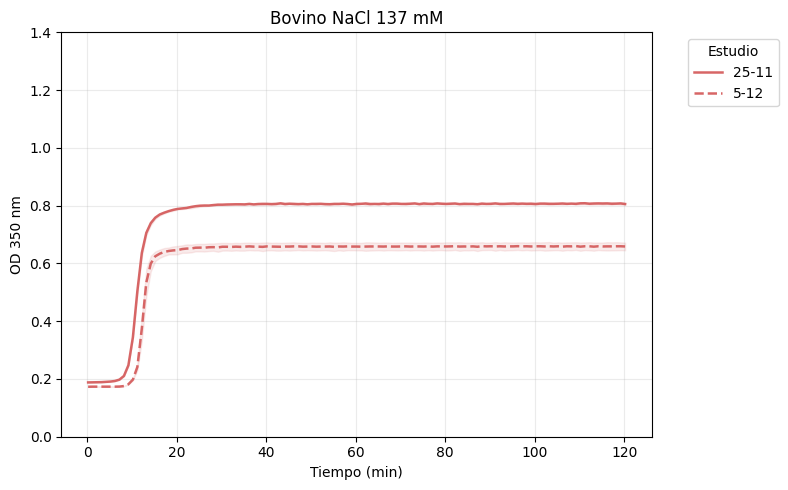

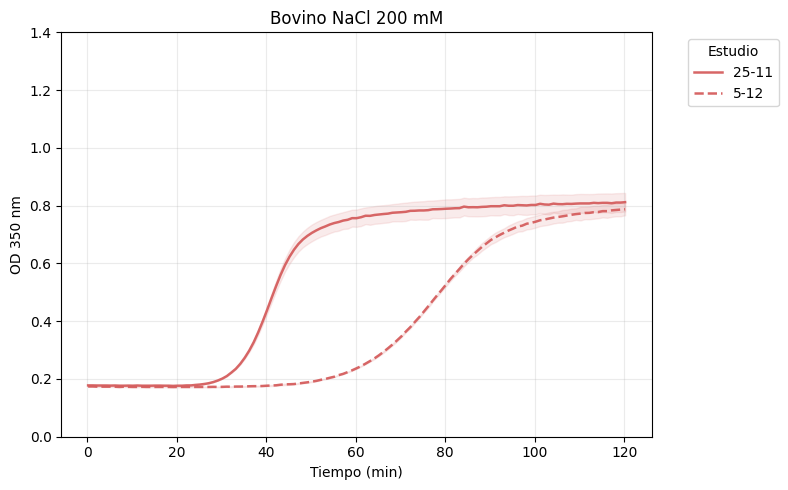

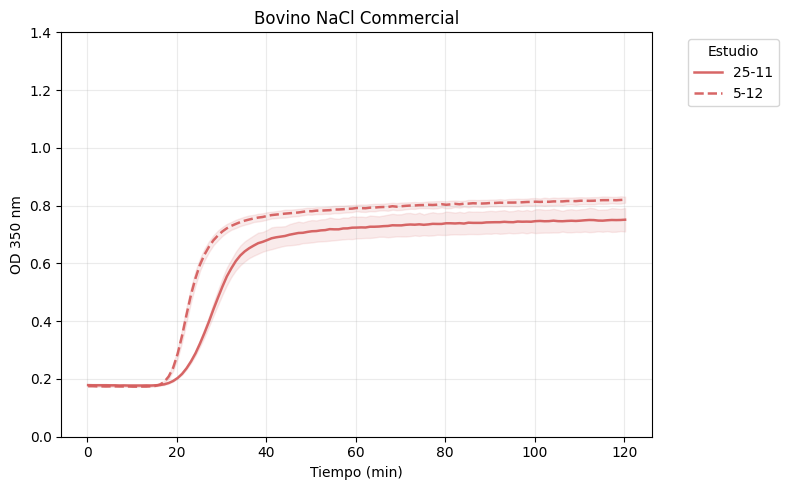

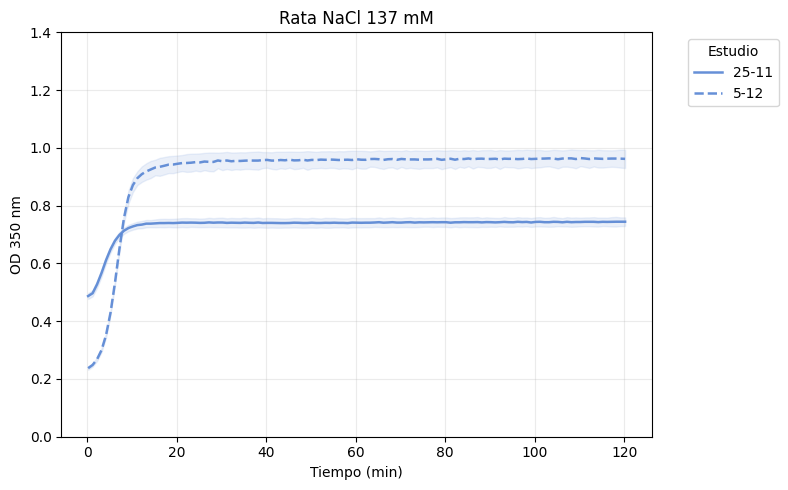

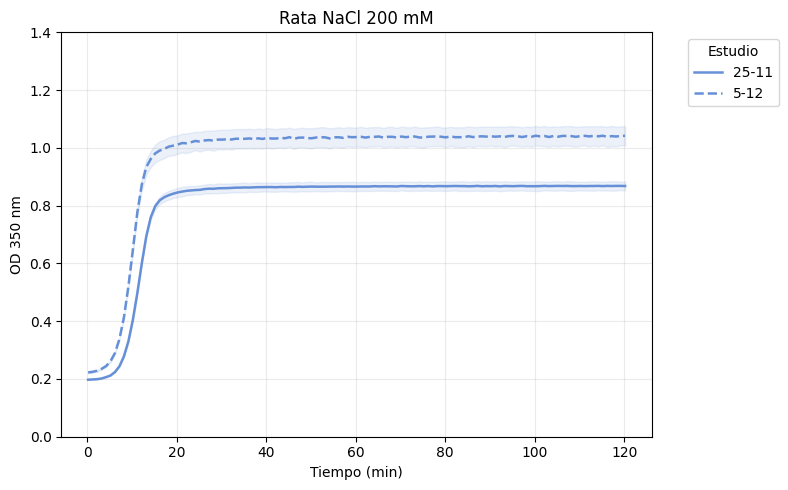

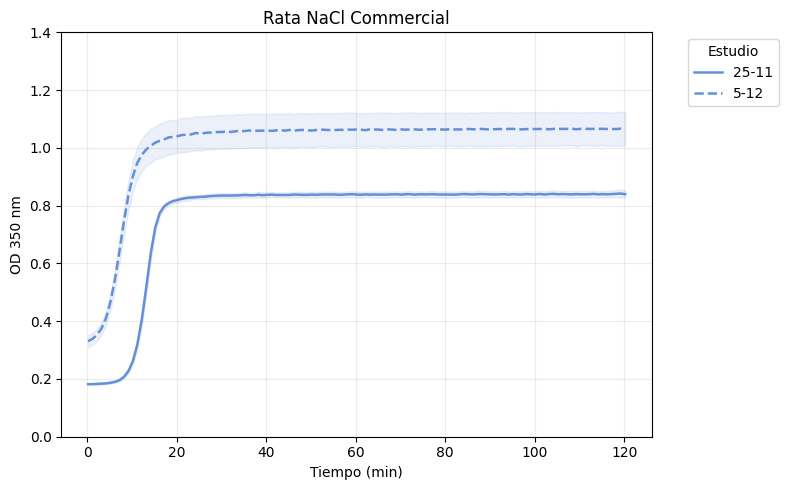

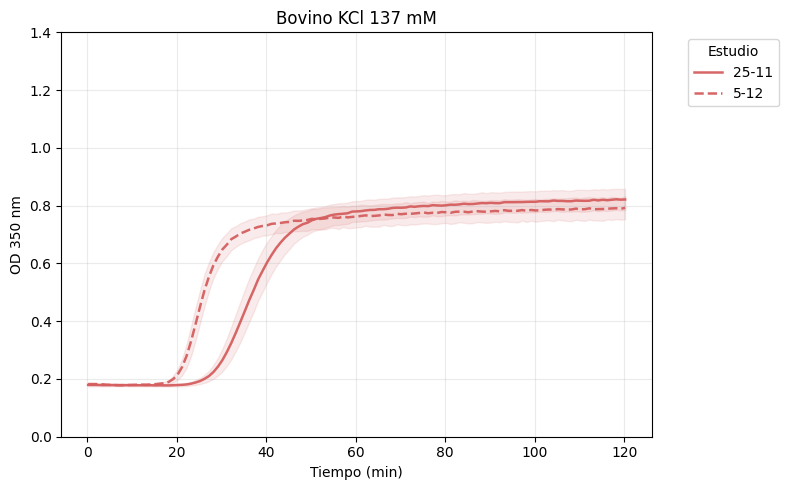

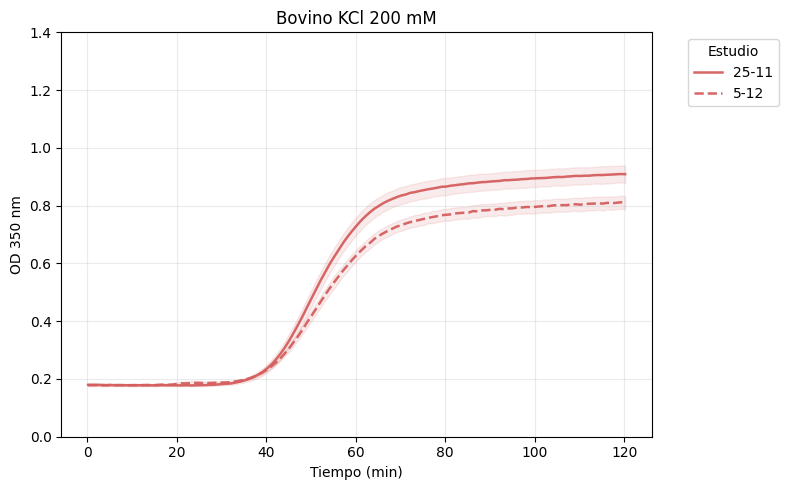

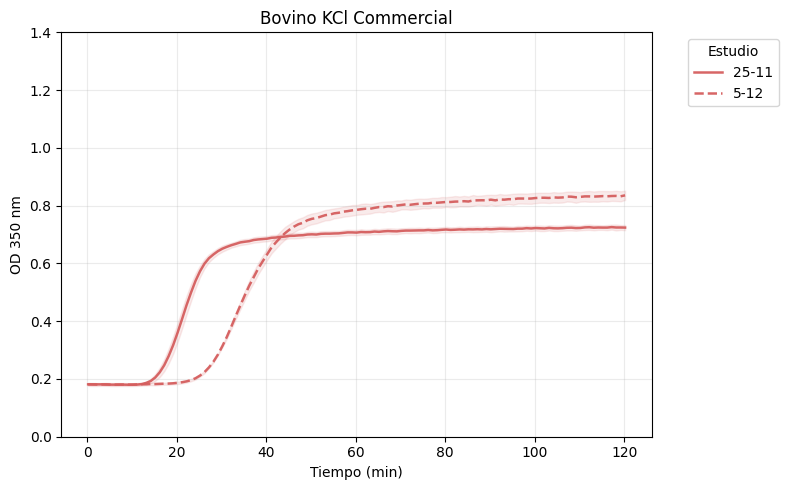

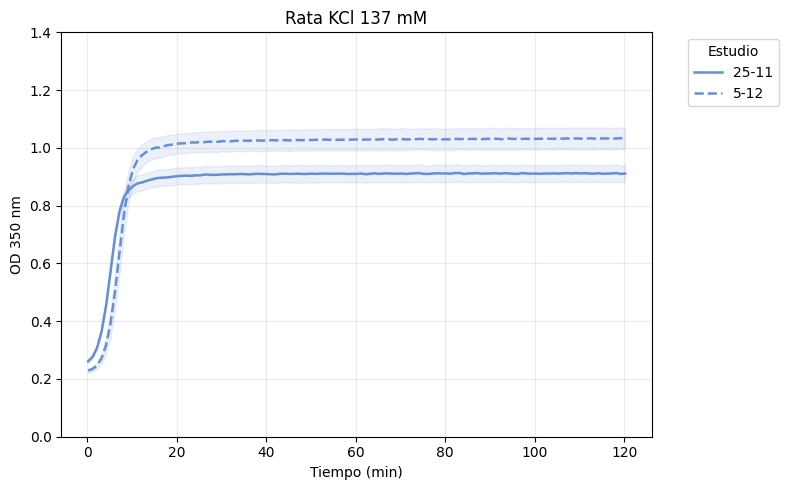

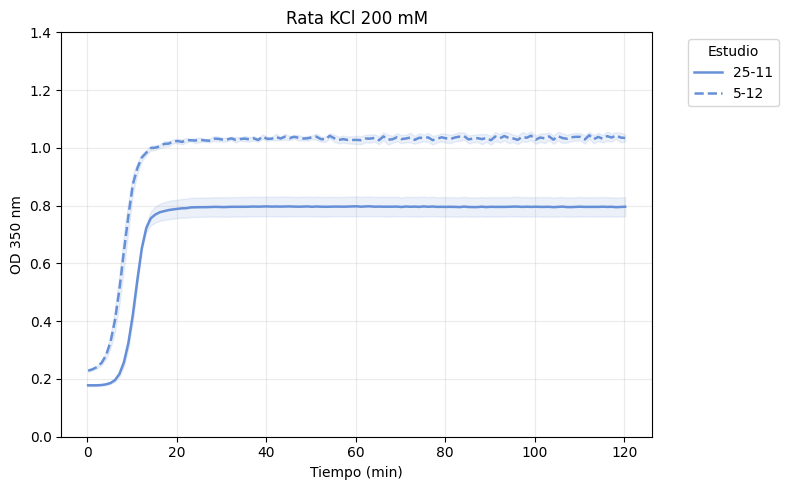

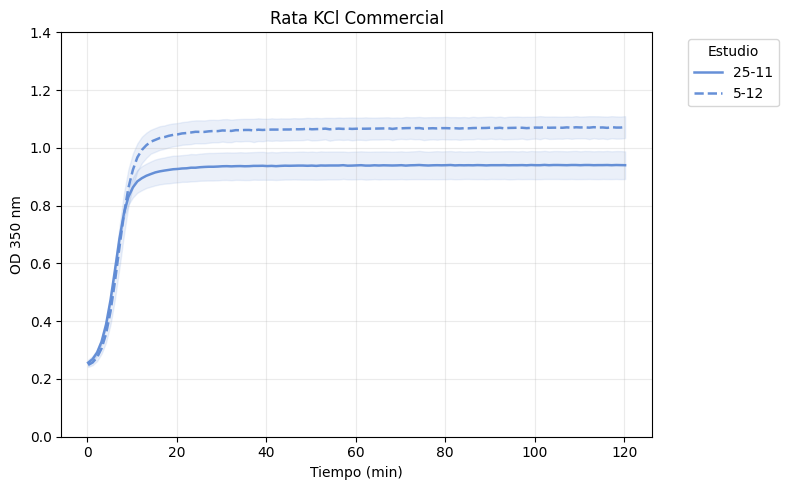

In [4]:
# ---- NaCl BOVINO ----
for conc in ["137 mM", "200 mM", "Commercial"]:
    pH = "pH 6" if conc == "137 mM" else None
    plot_study_comparison(all_df, "Bovine", "NaCl", conc, pH_filter=pH)

# ---- NaCl RATA ----
for conc in ["137 mM", "200 mM", "Commercial"]:
    pH = "pH 6" if conc == "137 mM" else None
    plot_study_comparison(all_df, "Rat", "NaCl", conc, pH_filter=pH)

# ---- KCl BOVINO ----
for conc in ["137 mM", "200 mM", "Commercial"]:
    plot_study_comparison(all_df, "Bovine", "KCl", conc)

# ---- KCl RATA ----
for conc in ["137 mM", "200 mM", "Commercial"]:
    plot_study_comparison(all_df, "Rat", "KCl", conc)


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_conc_both_species(df, salt, conc, pH_filter=None):
    # Filtramos por sal, concentración y solo Bovine/Rat
    sub = df[
        (df["salt"] == salt) &
        (df["conc"] == conc) &
        (df["species"].isin(["Bovine", "Rat"]))
    ].copy()

    if pH_filter is not None:
        sub = sub[sub["pH_group"] == pH_filter].copy()

    if sub.empty:
        print("No hay datos para:", salt, conc, "pH:", pH_filter)
        return

    # sem
    def sem(x):
        return x.std(ddof=1) / np.sqrt(len(x))

    stats = (
        sub
        .groupby(["time_min", "species", "study"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
    )

    plt.figure(figsize=(8,5))

    # Recorremos especie + estudio
    for (species, study_name), sub_st in stats.groupby(["species", "study"]):
        sub_st = sub_st.sort_values("time_min")

        # color por especie (+ pH si aplica)
        color = get_color(species, pH_filter if pH_filter is not None else "unaltered/NA")

        # estilo de línea: día
        ls = "-" if study_name == "25-11" else "--"



        # línea principal
        plt.plot(sub_st["time_min"], sub_st["mean"],
                 color=color, linestyle=ls, linewidth=1.8,
                 alpha=0.95, label=label)

        # banda SE
        plt.fill_between(sub_st["time_min"],
                         sub_st["mean"] - sub_st["sem"],
                         sub_st["mean"] + sub_st["sem"],
                         color=color, alpha=0.12)

    # Título: 1 por concentración (NaCl 137 mM, etc.)
    titulo = f"{salt} {conc}"
    plt.title(titulo)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pbs_comercial(all_df):
    # Filtramos solo PBS comercial (conc = "Commercial")
    sub = all_df[
        (all_df["conc"] == "Commercial") &
        (all_df["species"].isin(["Bovine", "Rat"]))  # quitamos control
    ].copy()

    if sub.empty:
        print("No hay datos de PBS comercial en all_df.")
        return

    # Media ± SEM por tiempo y condición
    def sem(x):
        return x.std(ddof=1) / np.sqrt(len(x))

    stats = (
        sub
        .groupby(["time_min", "study", "species", "salt", "pH_group"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
        .sort_values("time_min")
    )

    plt.figure(figsize=(9,6))

    for (study, species, salt, pH), g in stats.groupby(
        ["study", "species", "salt", "pH_group"]
    ):
        g = g.sort_values("time_min")

        # color: especie (bovino rojo, rata azul) + pH si aplica
        color = get_color(species, pH)

        # estilo por tipo de sal
        if salt == "NaCl":
            ls_salt = "-"
        elif salt == "KCl":
            ls_salt = "--"
        else:
            ls_salt = "-."

        # marcador por día de experimento
        marker = "o" if study == "25-11" else None

        # etiqueta bonita
        especie_es = "Bovino" if species == "Bovine" else "Rata"
        label = f"{especie_es} {salt} {study}"

        # curva
        plt.plot(
            g["time_min"], g["mean"],
            color=color,
            linestyle=ls_salt,
            linewidth=1.8,
            marker=marker,
            markersize=3,
            alpha=0.95,
            label=label
        )

        # banda de SE
        plt.fill_between(
            g["time_min"],
            g["mean"] - g["sem"],
            g["mean"] + g["sem"],
            color=color,
            alpha=0.10
        )

    plt.title("PBS comercial (NaCl y KCl, 1.5 mg/mL)")
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Condición")
    plt.tight_layout()
    plt.show()


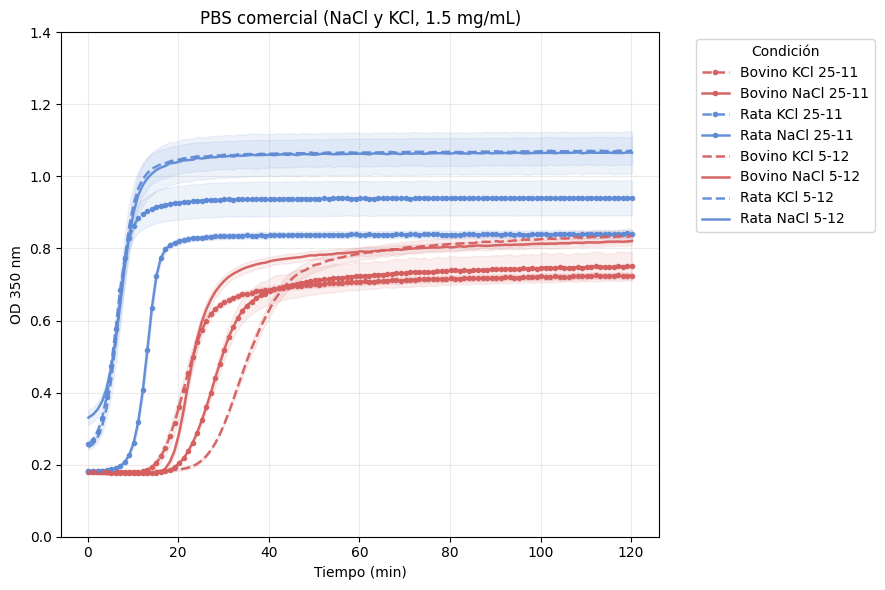

In [8]:
plot_pbs_comercial(all_df)


In [6]:
# ===== NaCl: 1 gráfica por concentración, juntando Bovino + Rata =====
for conc in ["137 mM", "200 mM", "Commercial"]:
    # Solo NaCl 137 mM → pH 6
    pH = "pH 6" if conc == "137 mM" else None
    plot_conc_both_species(all_df, salt="NaCl", conc=conc, pH_filter=pH)

# ===== KCl: 1 gráfica por concentración, juntando Bovino + Rata =====
for conc in ["137 mM", "200 mM", "Commercial"]:
    # Para KCl no filtramos pH (se usan todos los datos)
    plot_conc_both_species(all_df, salt="KCl", conc=conc, pH_filter=None)


NameError: name 'label' is not defined

<Figure size 800x500 with 0 Axes>

In [12]:
def get_color_study(species, study):
    """Colores para diferenciar especies + día."""
    if species == "Bovine":
        dark  = "#7f0000"   # granate p/día 25-11
        light = "#d55e5e"   # rojo claro p/día 5-12
    elif species == "Rat":
        dark  = "#00007f"   # azul marino
        light = "#5e8ad5"   # azul claro
    else:
        dark = light = "black"

    return dark if study == "25-11" else light


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pbs_commercial_salt(all_df, salt):
    """
    salt = "NaCl" o "KCl"
    Grafica Rata + Bovino juntos para PBS Commercial de esa sal.
    """
    sub = all_df[
        (all_df["conc"] == "Commercial") &
        (all_df["salt"] == salt) &
        (all_df["species"].isin(["Bovine", "Rat"]))
    ].copy()

    if sub.empty:
        print("No hay datos para PBS Commercial con", salt)
        return

    # SEM
    def sem(x):
        return x.std(ddof=1) / np.sqrt(len(x))

    stats = (
        sub
        .groupby(["time_min", "study", "species"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
        .sort_values("time_min")
    )

    plt.figure(figsize=(8,5))

    for (study, species), g in stats.groupby(["study","species"]):
        g = g.sort_values("time_min")

        color = get_color_study(species, study)

        # Línea siempre continua (solo una sal por gráfica)
        ls = "-"

        especie_es = "Bovino" if species == "Bovine" else "Rata"
        label = f"{especie_es} {study}"

        plt.plot(
            g["time_min"], g["mean"],
            color=color, linestyle=ls, linewidth=1.8,
            alpha=0.95, label=label
        )

        plt.fill_between(
            g["time_min"],
            g["mean"] - g["sem"],
            g["mean"] + g["sem"],
            color=color, alpha=0.12
        )

    titulo = f"{salt} – PBS Comercial (1.5 mg/mL)"
    plt.title(titulo)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()


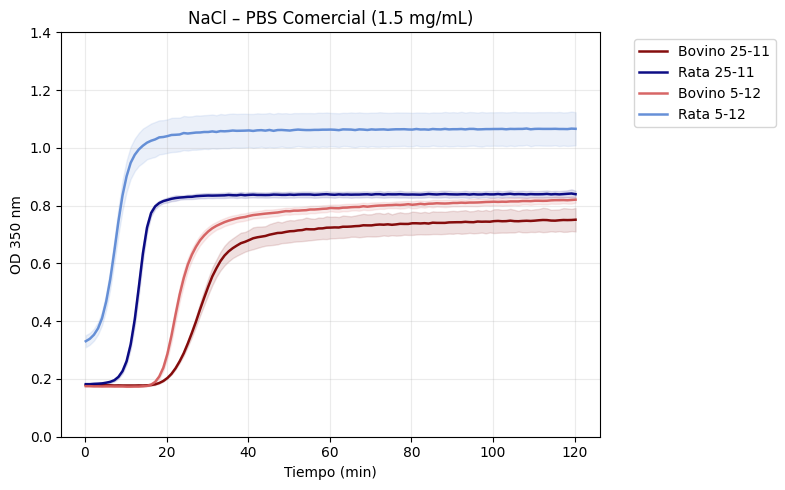

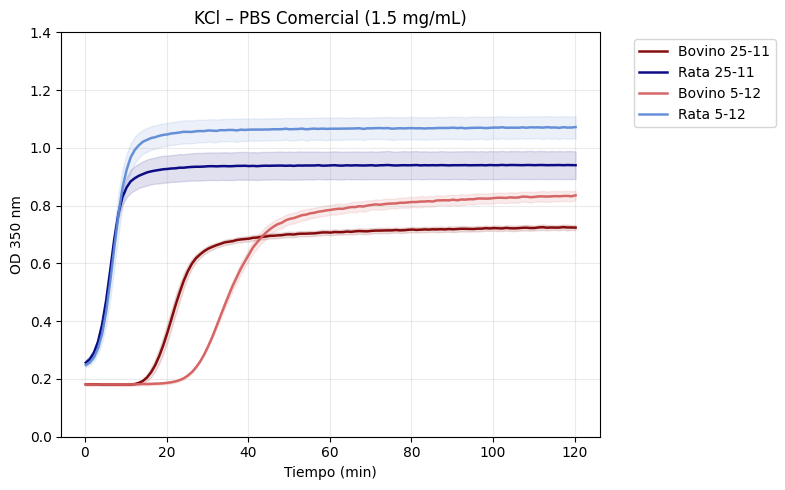

In [14]:
plot_pbs_commercial_salt(all_df, salt="NaCl")
plot_pbs_commercial_salt(all_df, salt="KCl")


In [15]:
def get_color_study(species, study):
    """
    Colores para diferenciar especie + día:
    - Bovine: granate (25-11) y rojo claro (5-12)
    - Rat: azul marino (25-11) y azul claro (5-12)
    """
    if species == "Bovine":
        dark  = "#7f0000"   # granate
        light = "#d55e5e"   # rojo claro
    elif species == "Rat":
        dark  = "#00007f"   # azul marino
        light = "#5e8ad5"   # azul claro
    else:
        dark = light = "black"

    return dark if study == "25-11" else light


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pbs_commercial_all(all_df):
    # Filtramos SOLO PBS commercial, NaCl/KCl y Rata/Bovino
    sub = all_df[
        (all_df["conc"] == "Commercial") &
        (all_df["salt"].isin(["NaCl", "KCl"])) &
        (all_df["species"].isin(["Bovine", "Rat"]))
    ].copy()

    if sub.empty:
        print("No hay datos PBS Commercial (NaCl/KCl) en all_df.")
        return

    # SEM
    def sem(x):
        return x.std(ddof=1) / np.sqrt(len(x))

    stats = (
        sub
        .groupby(["time_min", "study", "species", "salt"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
        .sort_values("time_min")
    )

    # Tipo de línea por sal
    ls_map = {
        "NaCl": "-",
        "KCl": "--",
    }

    plt.figure(figsize=(9,6))

    for (study, species, salt), g in stats.groupby(["study","species","salt"]):
        g = g.sort_values("time_min")

        color = get_color_study(species, study)
        ls = ls_map.get(salt, "-")

        especie_es = "Bovino" if species == "Bovine" else "Rata"
        label = f"{especie_es} {salt} {study}"

        # curva principal
        plt.plot(
            g["time_min"], g["mean"],
            color=color,
            linestyle=ls,
            linewidth=1.8,
            alpha=0.95,
            label=label
        )

        # banda ± SEM
        plt.fill_between(
            g["time_min"],
            g["mean"] - g["sem"],
            g["mean"] + g["sem"],
            color=color,
            alpha=0.10
        )

    plt.title("PBS Commercial – NaCl y KCl (Rata/Bovino, 1.5 mg/mL)")
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Condición")
    plt.tight_layout()
    plt.show()


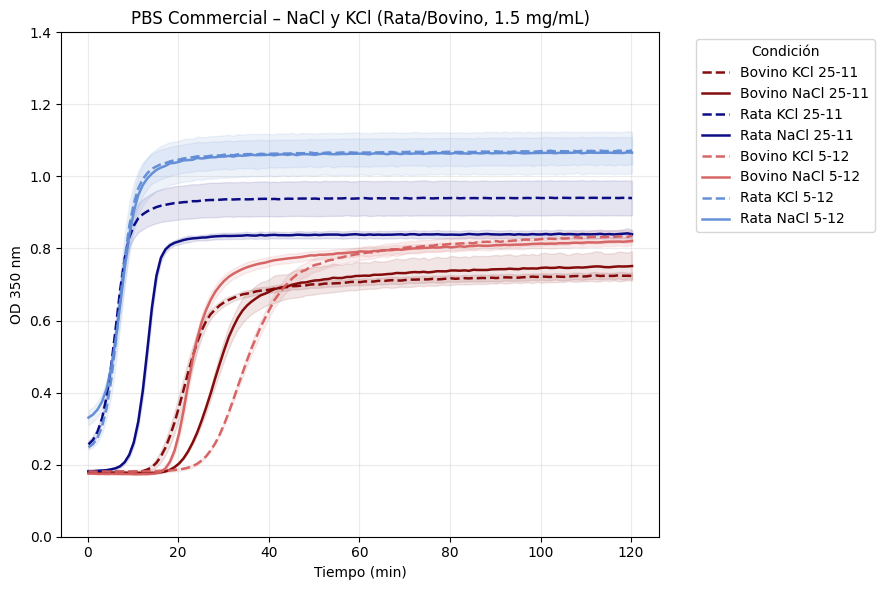

In [17]:
plot_pbs_commercial_all(all_df)


In [18]:
def get_color_study(species, study):
    """
    Colores para especie + día:
    - Bovine: granate (25-11) y rojo claro (5-12)
    - Rat: azul marino (25-11) y azul claro (5-12)
    """
    if species == "Bovine":
        dark  = "#7f0000"   # granate
        light = "#d55e5e"   # rojo claro
    elif species == "Rat":
        dark  = "#00007f"   # azul marino
        light = "#5e8ad5"   # azul claro
    else:
        dark = light = "black"

    return dark if study == "25-11" else light


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mixed_salts_days(all_df, pair_list, title):
    """
    pair_list = lista de tuplas (study, salt) que quieres incluir.
    Ej: [("25-11","KCl"), ("5-12","NaCl")]
    """
    # Filtramos PBS Commercial, solo NaCl/KCl, Rata/Bovino
    sub = all_df[
        (all_df["conc"] == "Commercial") &
        (all_df["salt"].isin(["NaCl", "KCl"])) &
        (all_df["species"].isin(["Bovine", "Rat"]))
    ].copy()

    # Filtrar por los pares (study, salt) que nos interesan
    mask = False
    for st, sa in pair_list:
        mask |= ((sub["study"] == st) & (sub["salt"] == sa))
    sub = sub[mask].copy()

    if sub.empty:
        print("No hay datos para esa combinación:", pair_list)
        return

    # SEM
    def sem(x):
        return x.std(ddof=1) / np.sqrt(len(x))

    stats = (
        sub
        .groupby(["time_min", "study", "species", "salt"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
        .sort_values("time_min")
    )

    # estilo de línea por sal
    ls_map = {
        "NaCl": "-",
        "KCl": "--",
    }

    plt.figure(figsize=(8,5))

    for (study, species, salt), g in stats.groupby(["study","species","salt"]):
        g = g.sort_values("time_min")

        color = get_color_study(species, study)
        ls = ls_map.get(salt, "-")

        especie_es = "Bovino" if species == "Bovine" else "Rata"
        label = f"{especie_es} {salt} {study}"

        plt.plot(
            g["time_min"], g["mean"],
            color=color, linestyle=ls, linewidth=1.8,
            alpha=0.95, label=label
        )

        plt.fill_between(
            g["time_min"],
            g["mean"] - g["sem"],
            g["mean"] + g["sem"],
            color=color, alpha=0.10
        )

    plt.title(title)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()


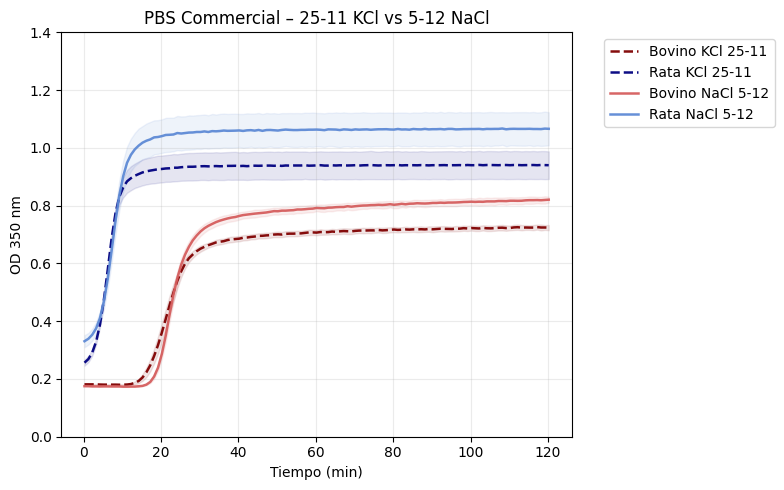

In [20]:
plot_mixed_salts_days(
    all_df,
    pair_list=[("25-11", "KCl"), ("5-12", "NaCl")],
    title="PBS Commercial – 25-11 KCl vs 5-12 NaCl"
)


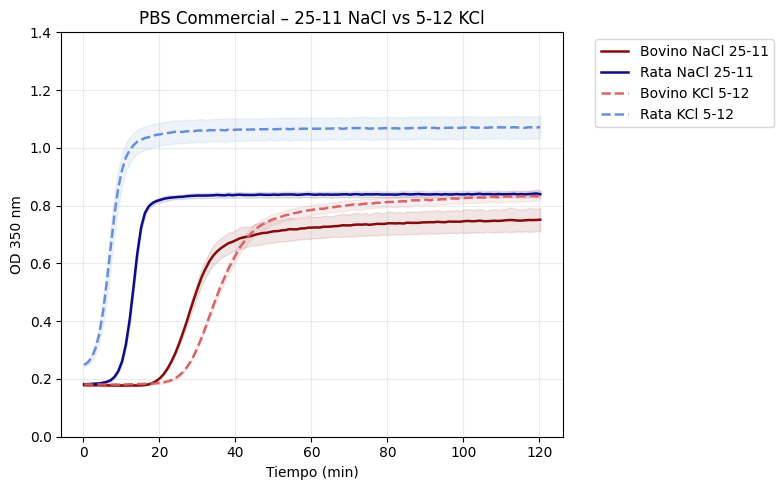

In [21]:
plot_mixed_salts_days(
    all_df,
    pair_list=[("25-11", "NaCl"), ("5-12", "KCl")],
    title="PBS Commercial – 25-11 NaCl vs 5-12 KCl"
)


In [22]:
def get_color_species(species):
    if species == "Bovine":
        return "#d55e5e"   # rojo suave
    elif species == "Rat":
        return "#5e8ad5"   # azul suave
    else:
        return "black"


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pbs_commercial_day(all_df, study):
    """
    all_df: dataframe combinado con columnas:
            time_min, OD, species, salt, conc, study, ...
    study: "25-11" o "5-12"
    """
    sub = all_df[
        (all_df["conc"] == "Commercial") &
        (all_df["study"] == study) &
        (all_df["salt"].isin(["NaCl", "KCl"])) &
        (all_df["species"].isin(["Bovine", "Rat"]))
    ].copy()

    if sub.empty:
        print("No hay datos PBS Commercial para el día", study)
        return

    # SEM
    def sem(x):
        return x.std(ddof=1) / np.sqrt(len(x))

    stats = (
        sub
        .groupby(["time_min", "species", "salt"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
        .sort_values("time_min")
    )

    # estilo de línea por sal
    ls_map = {
        "NaCl": "-",
        "KCl": "--",
    }

    plt.figure(figsize=(8,5))

    for (species, salt), g in stats.groupby(["species","salt"]):
        g = g.sort_values("time_min")

        color = get_color_species(species)
        ls = ls_map.get(salt, "-")

        especie_es = "Bovino" if species == "Bovine" else "Rata"
        label = f"{especie_es} {salt}"

        plt.plot(
            g["time_min"], g["mean"],
            color=color,
            linestyle=ls,
            linewidth=1.8,
            alpha=0.95,
            label=label
        )

        plt.fill_between(
            g["time_min"],
            g["mean"] - g["sem"],
            g["mean"] + g["sem"],
            color=color,
            alpha=0.10
        )

    titulo = f"PBS Commercial – {study}"
    plt.title(titulo)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Condición")
    plt.tight_layout()
    plt.show()


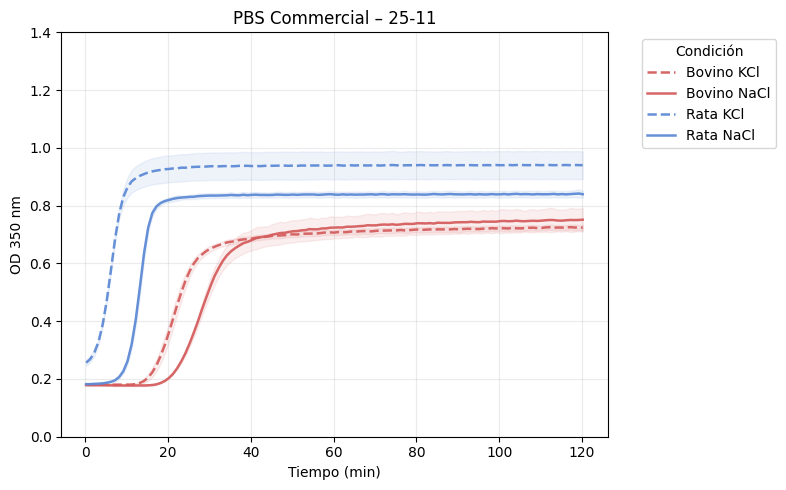

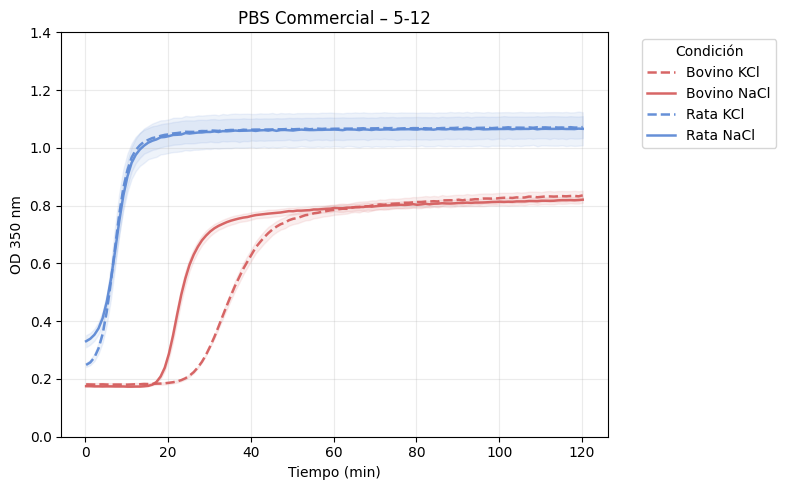

In [24]:
# Día 1: 25-11
plot_pbs_commercial_day(all_df, study="25-11")

# Día 2: 5-12
plot_pbs_commercial_day(all_df, study="5-12")


In [25]:
def reorder_legend(ax, order_list):
    """
    order_list: lista de etiquetas EXACTAS en el orden deseado.
    """
    handles, labels = ax.get_legend_handles_labels()

    # crear un diccionario etiqueta → handle
    lbl_to_hndl = {lbl: h for h, lbl in zip(handles, labels)}

    # generar nueva lista en el orden que tú quieres
    new_handles = [lbl_to_hndl[lbl] for lbl in order_list if lbl in lbl_to_hndl]
    new_labels  = [lbl for lbl in order_list if lbl in lbl_to_hndl]

    ax.legend(new_handles, new_labels, bbox_to_anchor=(1.05,1), loc="upper left")


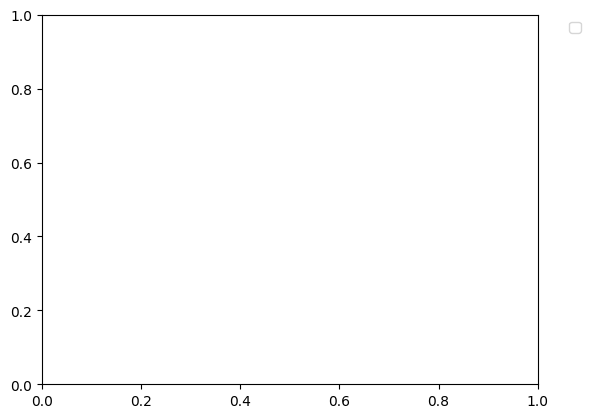

In [26]:
orden_25 = [
    "Rata KCl",
    "Bovino KCl",
    "Rata NaCl",
    "Bovino NaCl"
]

reorder_legend(plt.gca(), orden_25)


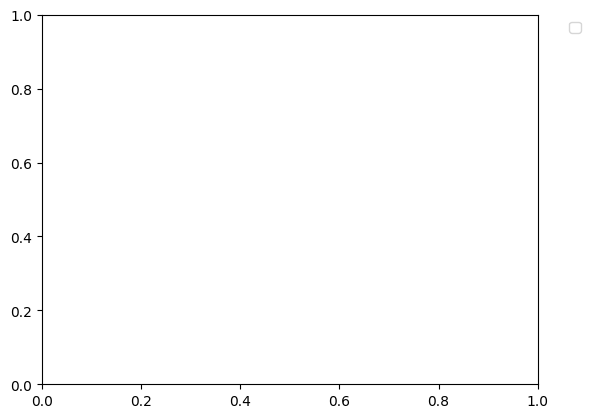

In [27]:
orden_5 = [
    "Bovino NaCl",
    "Rata NaCl",
    "Bovino KCl",
    "Rata KCl"
]

reorder_legend(plt.gca(), orden_5)


In [28]:
import matplotlib.pyplot as plt
import numpy as np

def get_color_species(species):
    if species == "Bovine":
        return "#d55e5e"   # rojo
    elif species == "Rat":
        return "#5e8ad5"   # azul
    else:
        return "black"


def reorder_legend_day(ax, study):
    """
    Orden de leyenda:
    - 25-11: Rata KCl, Bovino KCl, Rata NaCl, Bovino NaCl
    - 5-12:  Bovino NaCl, Rata NaCl, Bovino KCl, Rata KCl
    """
    if study == "25-11":
        order = ["Rata KCl", "Bovino KCl", "Rata NaCl", "Bovino NaCl"]
    elif study == "5-12":
        order = ["Bovino NaCl", "Rata NaCl", "Bovino KCl", "Rata KCl"]
    else:
        # si es otro día, deja la leyenda tal cual
        ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
        return

    handles, labels = ax.get_legend_handles_labels()
    lbl_to_h = {lbl: h for h, lbl in zip(handles, labels)}

    new_handles = [lbl_to_h[lbl] for lbl in order if lbl in lbl_to_h]
    new_labels  = [lbl for lbl in order if lbl in lbl_to_h]

    ax.legend(new_handles, new_labels, bbox_to_anchor=(1.05,1), loc="upper left")


def plot_pbs_commercial_day(all_df, study):
    """
    Dibuja para un día:
    - Rata/Bovino
    - NaCl/KCl
    - conc = Commercial
    y ordena la leyenda según lo que has pedido.
    """
    sub = all_df[
        (all_df["conc"] == "Commercial") &
        (all_df["study"] == study) &
        (all_df["salt"].isin(["NaCl", "KCl"])) &
        (all_df["species"].isin(["Bovine", "Rat"]))
    ].copy()

    if sub.empty:
        print("No hay datos PBS Commercial para el día", study)
        return

    def sem(x):
        return x.std(ddof=1) / np.sqrt(len(x))

    stats = (
        sub
        .groupby(["time_min", "species", "salt"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
        .sort_values("time_min")
    )

    ls_map = {"NaCl": "-", "KCl": "--"}

    fig, ax = plt.subplots(figsize=(8,5))

    for (species, salt), g in stats.groupby(["species","salt"]):
        g = g.sort_values("time_min")

        color = get_color_species(species)
        ls = ls_map.get(salt, "-")

        especie_es = "Bovino" if species == "Bovine" else "Rata"
        label = f"{especie_es} {salt}"   # OJO: coincide con los órdenes de arriba

        ax.plot(
            g["time_min"], g["mean"],
            color=color, linestyle=ls,
            linewidth=1.8, alpha=0.95,
            label=label
        )

        ax.fill_between(
            g["time_min"],
            g["mean"] - g["sem"],
            g["mean"] + g["sem"],
            color=color, alpha=0.10
        )

    ax.set_title(f"PBS Commercial – {study}")
    ax.set_xlabel("Tiempo (min)")
    ax.set_ylabel("OD 350 nm")
    ax.grid(True, alpha=0.25)
    ax.set_ylim(0, 1.4)

    # 👉 aquí reordenamos la leyenda según el día
    reorder_legend_day(ax, study)

    plt.tight_layout()
    plt.show()


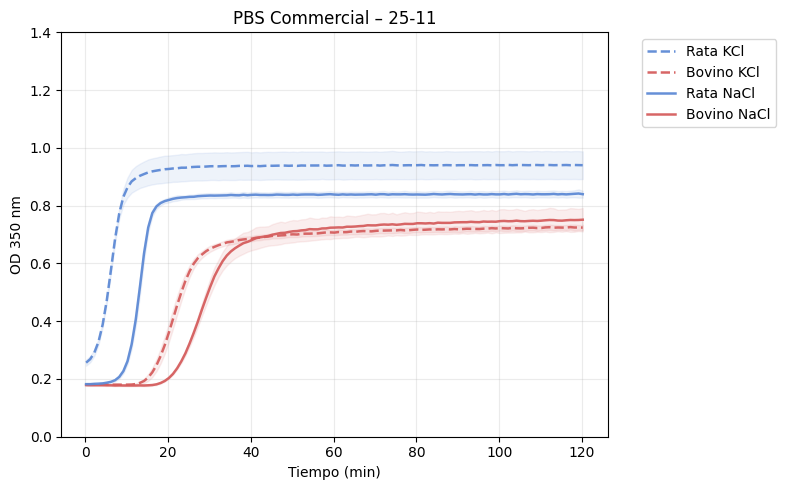

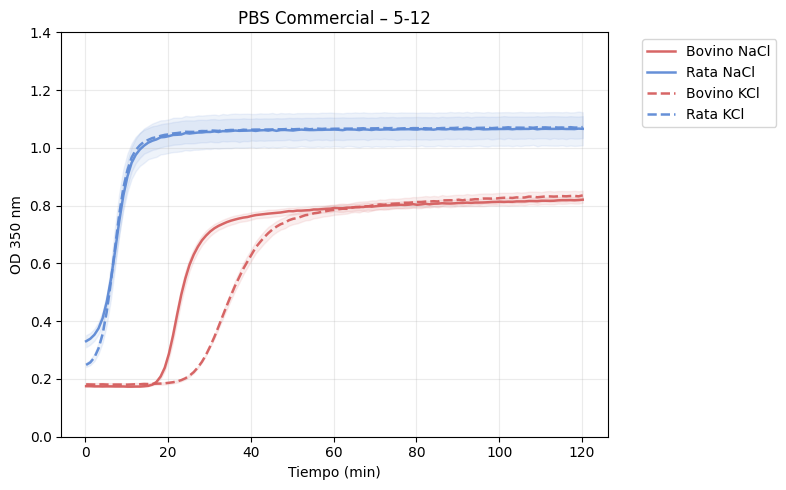

In [29]:
plot_pbs_commercial_day(all_df, "25-11")
plot_pbs_commercial_day(all_df, "5-12")


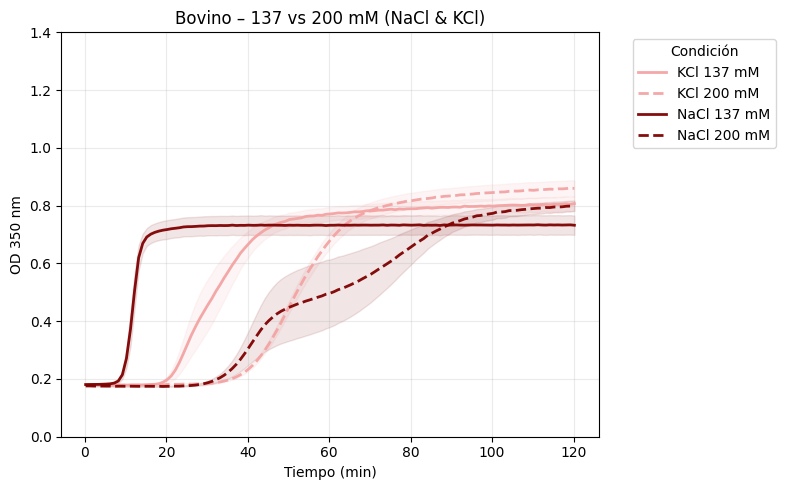

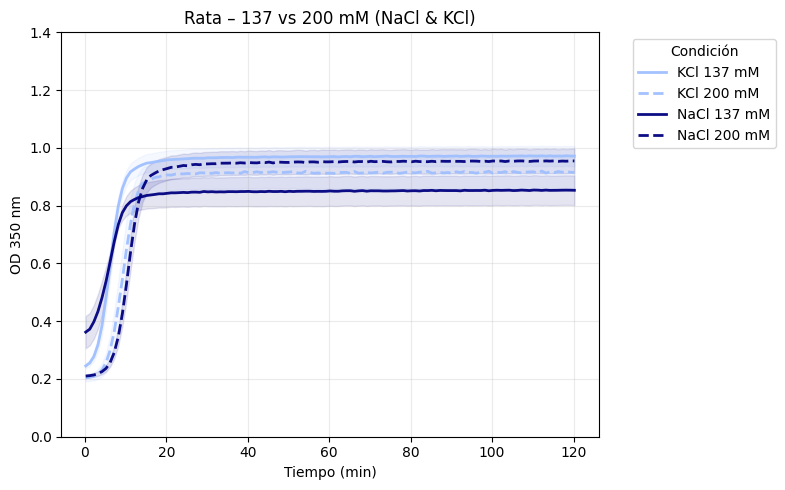

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_species_137_vs_200(all_df, species):
    """
    Hace una gráfica para una especie (Bovine o Rat)
    comparando:
      NaCl 137 vs 200 mM
      KCl  137 vs 200 mM
    """

    # Filtramos solo esa especie y esas concentraciones
    sub = all_df[
        (all_df["species"] == species) &
        (all_df["salt"].isin(["NaCl", "KCl"])) &
        (all_df["conc"].isin(["137 mM", "200 mM"]))
    ].copy()

    # (Opcional) para NaCl 137 mM quedarnos solo con pH 6
    sub = sub[~((sub["salt"] == "NaCl") & (sub["conc"] == "137 mM") & (sub["pH_group"] != "pH 6"))]

    if sub.empty:
        print("No hay datos para", species, "en 137/200 mM.")
        return

    # Función SEM
    def sem(x):
        return x.std(ddof=1) / np.sqrt(len(x))

    stats = (
        sub
        .groupby(["time_min", "salt", "conc"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
        .sort_values("time_min")
    )

    # Colores por especie y sal
    # NaCl = más oscuro, KCl = más claro
    if species == "Bovine":
        nacl_dark = "#7f0000"
        kcl_light = "#f4a3a3"
    else:  # Rat
        nacl_dark = "#00007f"
        kcl_light = "#9fbfff"

    def get_color(salt):
        return nacl_dark if salt == "NaCl" else kcl_light

    # Estilo por concentración
    def get_ls(conc):
        return "-" if conc == "137 mM" else "--"

    plt.figure(figsize=(8,5))

    for (salt, conc), g in stats.groupby(["salt","conc"]):
        g = g.sort_values("time_min")

        color = get_color(salt)
        ls    = get_ls(conc)

        label = f"{salt} {conc}"

        plt.plot(
            g["time_min"], g["mean"],
            color=color,
            linestyle=ls,
            linewidth=2,
            alpha=0.95,
            label=label
        )

        plt.fill_between(
            g["time_min"],
            g["mean"] - g["sem"],
            g["mean"] + g["sem"],
            color=color,
            alpha=0.10
        )

    especie_es = "Bovino" if species == "Bovine" else "Rata"
    plt.title(f"{especie_es} – 137 vs 200 mM (NaCl & KCl)")
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Condición")
    plt.tight_layout()
    plt.show()


# ======= LLAMADAS =======

# Gráfica para Bovino
plot_species_137_vs_200(all_df, species="Bovine")

# Gráfica para Rata
plot_species_137_vs_200(all_df, species="Rat")


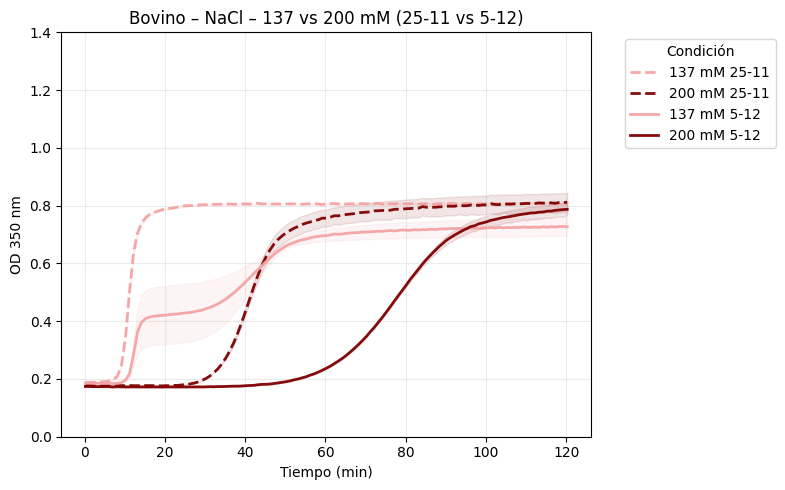

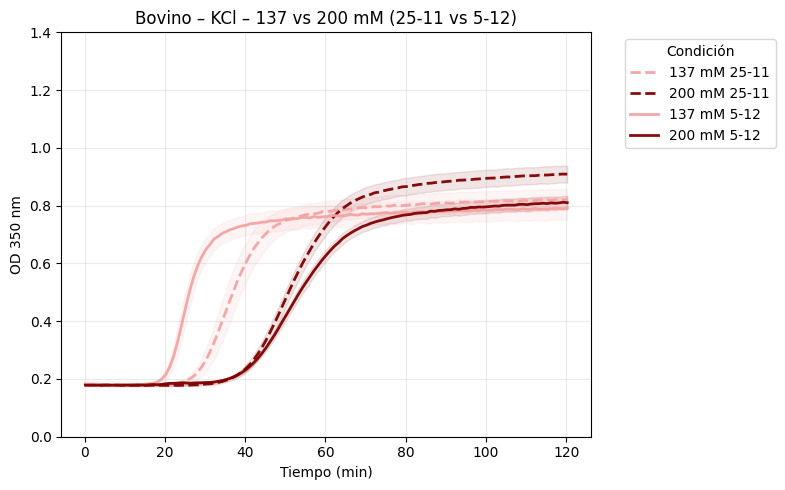

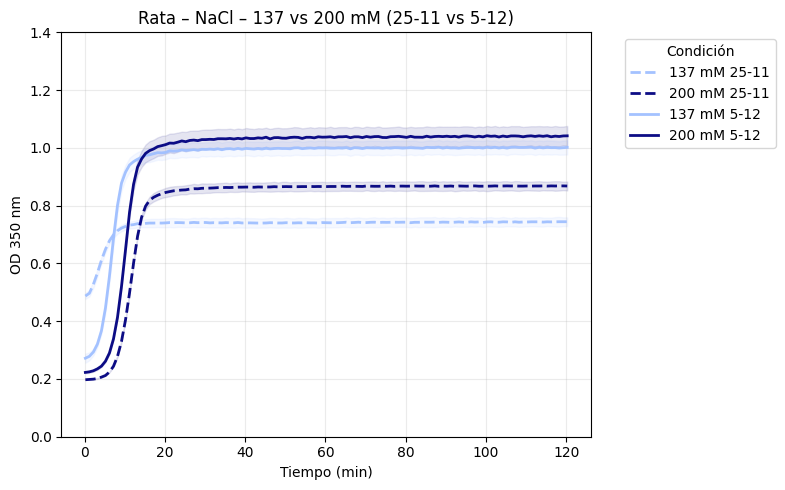

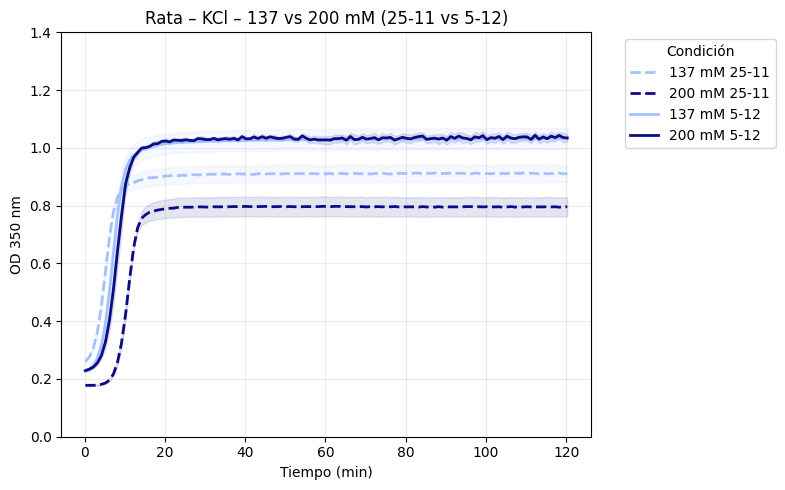

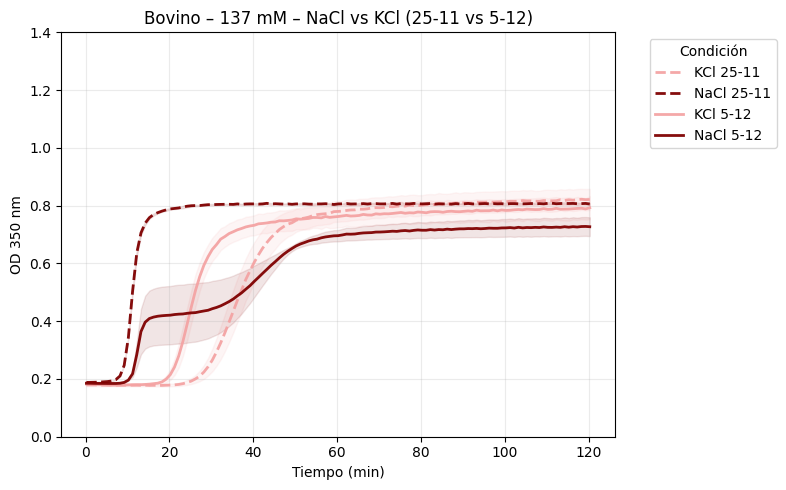

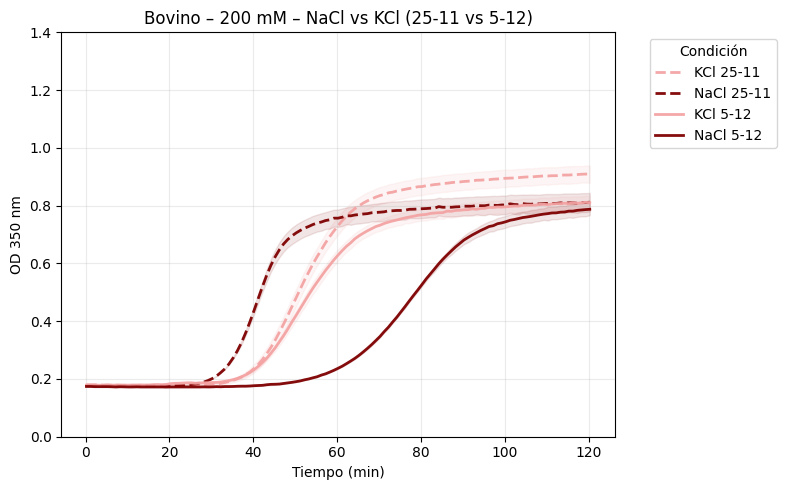

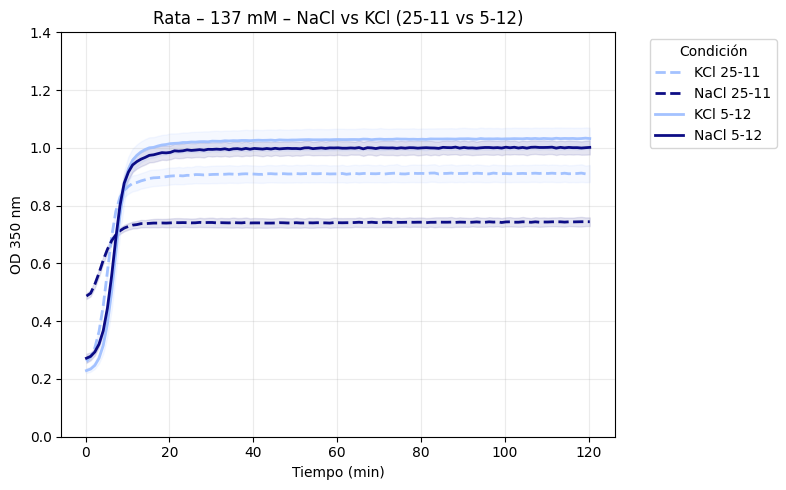

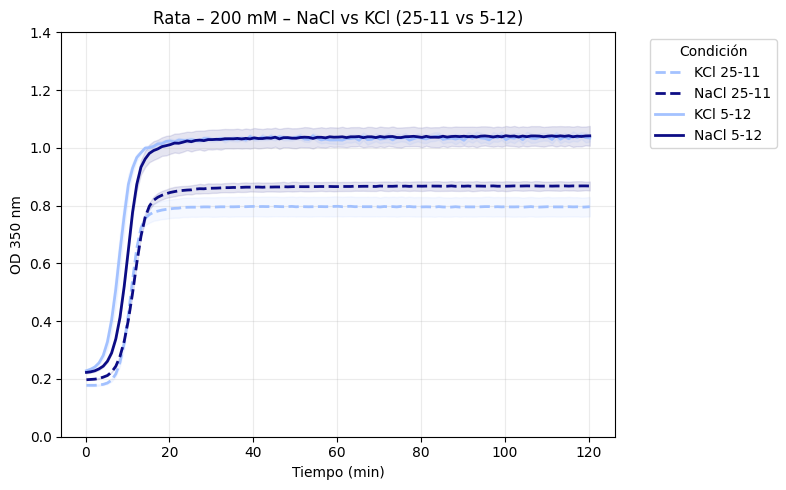

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# =============================
# Helper común: SEM
# =============================
def sem(x):
    return x.std(ddof=1) / np.sqrt(len(x))


# =========================================================
# 1. GRÁFICAS TIPO 1:
#    MISMA SAL (NaCl / KCl), 137 vs 200, COMPARANDO DÍAS
# =========================================================
def plot_species_conc_comparison(all_df, species, salt):
    """
    Una gráfica para:
      - especie concreta (Bovine / Rat)
      - UNA sal concreta (NaCl o KCl)
      - concentraciones 137 mM vs 200 mM
    137 mM → color más claro
    200 mM → color más intenso
    25-11 → línea discontinua
    5-12  → línea continua
    """

    sub = all_df[
        (all_df["species"] == species) &
        (all_df["salt"] == salt) &
        (all_df["conc"].isin(["137 mM", "200 mM"]))
    ].copy()

    # Si quieres, para NaCl 137 mM quedarte solo con pH 6:
    # sub = sub[~((sub["salt"] == "NaCl") & (sub["conc"] == "137 mM") & (sub["pH_group"] != "pH 6"))]

    if sub.empty:
        print("No hay datos para", species, salt, "en 137/200 mM.")
        return

    stats = (
        sub
        .groupby(["time_min", "study", "conc"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
        .sort_values("time_min")
    )

    # Colores base por especie
    if species == "Bovine":
        base_light = "#f4a3a3"  # clarito
        base_dark  = "#7f0000"  # intenso
        especie_es = "Bovino"
    else:
        base_light = "#9fbfff"
        base_dark  = "#00007f"
        especie_es = "Rata"

    def color_from_conc(conc):
        return base_light if conc == "137 mM" else base_dark

    def ls_from_day(study):
        return "--" if study == "25-11" else "-"

    plt.figure(figsize=(8,5))

    for (study, conc), g in stats.groupby(["study", "conc"]):
        g = g.sort_values("time_min")

        color = color_from_conc(conc)
        ls    = ls_from_day(study)

        label = f"{conc} {study}"

        plt.plot(
            g["time_min"], g["mean"],
            color=color,
            linestyle=ls,
            linewidth=2,
            alpha=0.95,
            label=label
        )

        plt.fill_between(
            g["time_min"],
            g["mean"] - g["sem"],
            g["mean"] + g["sem"],
            color=color,
            alpha=0.10
        )

    titulo = f"{especie_es} – {salt} – 137 vs 200 mM (25-11 vs 5-12)"
    plt.title(titulo)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Condición")
    plt.tight_layout()
    plt.show()


# =========================================================
# 2. GRÁFICAS TIPO 2:
#    MISMA CONC (137 / 200), NaCl vs KCl, COMPARANDO DÍAS
# =========================================================
def plot_species_salt_comparison(all_df, species, conc):
    """
    Una gráfica para:
      - especie concreta (Bovine / Rat)
      - UNA concentración (137 mM o 200 mM)
      - NaCl vs KCl
    NaCl  → color más fuerte
    KCl   → mismo tono más flojo
    25-11 → línea discontinua
    5-12  → línea continua
    """

    sub = all_df[
        (all_df["species"] == species) &
        (all_df["conc"] == conc) &
        (all_df["salt"].isin(["NaCl", "KCl"]))
    ].copy()

    # Si quieres restringir NaCl 137 a pH 6:
    # if conc == "137 mM":
    #     sub = sub[~((sub["salt"] == "NaCl") & (sub["pH_group"] != "pH 6"))]

    if sub.empty:
        print("No hay datos para", species, "en", conc, "NaCl/KCl.")
        return

    stats = (
        sub
        .groupby(["time_min", "study", "salt"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
        .sort_values("time_min")
    )

    # Colores por especie, NaCl fuerte / KCl flojo
    if species == "Bovine":
        nacl_strong = "#7f0000"
        kcl_weak    = "#f4a3a3"
        especie_es  = "Bovino"
    else:
        nacl_strong = "#00007f"
        kcl_weak    = "#9fbfff"
        especie_es  = "Rata"

    def color_from_salt(salt):
        return nacl_strong if salt == "NaCl" else kcl_weak

    def ls_from_day(study):
        return "--" if study == "25-11" else "-"

    plt.figure(figsize=(8,5))

    for (study, salt), g in stats.groupby(["study", "salt"]):
        g = g.sort_values("time_min")

        color = color_from_salt(salt)
        ls    = ls_from_day(study)

        label = f"{salt} {study}"

        plt.plot(
            g["time_min"], g["mean"],
            color=color,
            linestyle=ls,
            linewidth=2,
            alpha=0.95,
            label=label
        )

        plt.fill_between(
            g["time_min"],
            g["mean"] - g["sem"],
            g["mean"] + g["sem"],
            color=color,
            alpha=0.10
        )

    titulo = f"{especie_es} – {conc} – NaCl vs KCl (25-11 vs 5-12)"
    plt.title(titulo)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Condición")
    plt.tight_layout()
    plt.show()


# =========================================================
# 3. LLAMADAS → 8 GRÁFICAS
# =========================================================

# --- Bovino: concentración 137 vs 200 para NaCl y KCl ---
plot_species_conc_comparison(all_df, species="Bovine", salt="NaCl")
plot_species_conc_comparison(all_df, species="Bovine", salt="KCl")

# --- Rata: concentración 137 vs 200 para NaCl y KCl ---
plot_species_conc_comparison(all_df, species="Rat", salt="NaCl")
plot_species_conc_comparison(all_df, species="Rat", salt="KCl")

# --- Bovino: NaCl vs KCl para 137 y 200 ---
plot_species_salt_comparison(all_df, species="Bovine", conc="137 mM")
plot_species_salt_comparison(all_df, species="Bovine", conc="200 mM")

# --- Rata: NaCl vs KCl para 137 y 200 ---
plot_species_salt_comparison(all_df, species="Rat", conc="137 mM")
plot_species_salt_comparison(all_df, species="Rat", conc="200 mM")


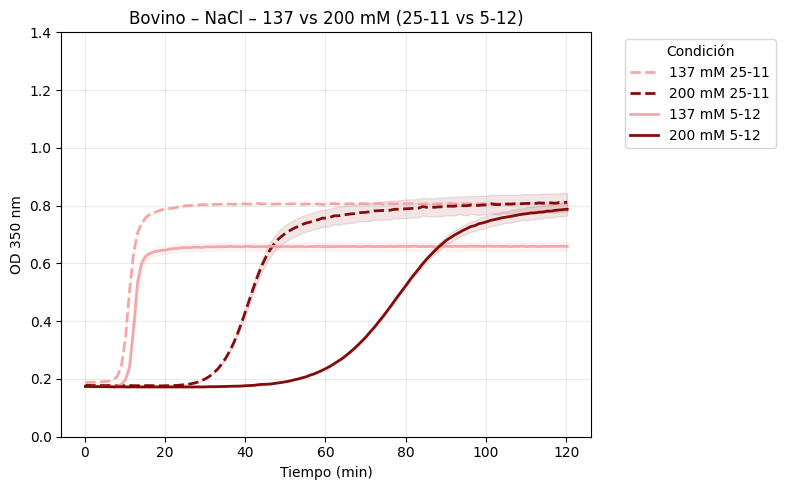

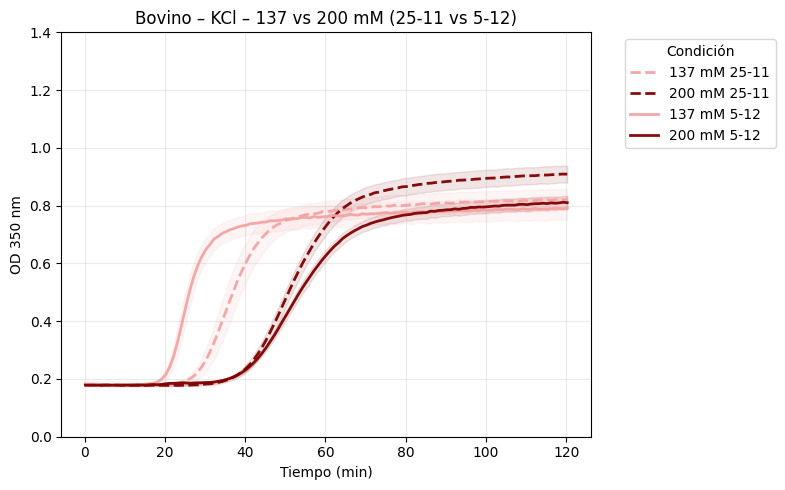

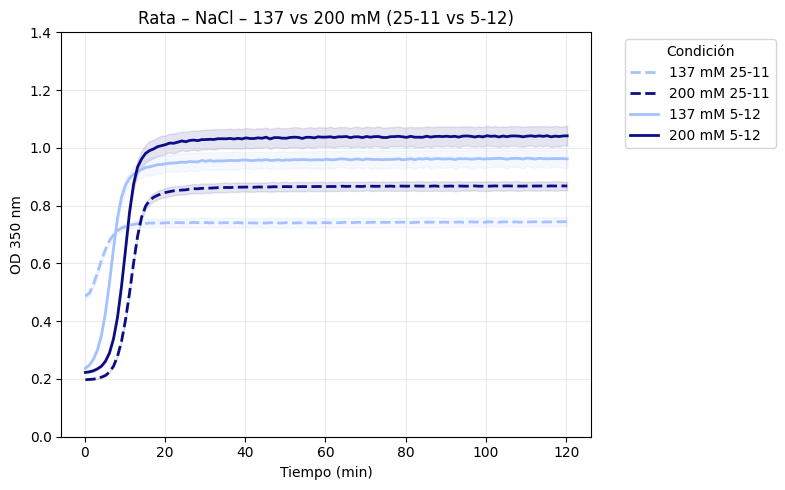

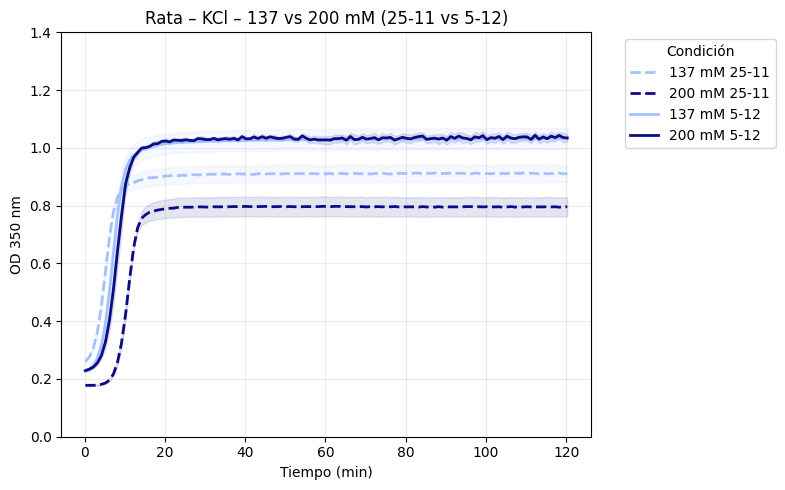

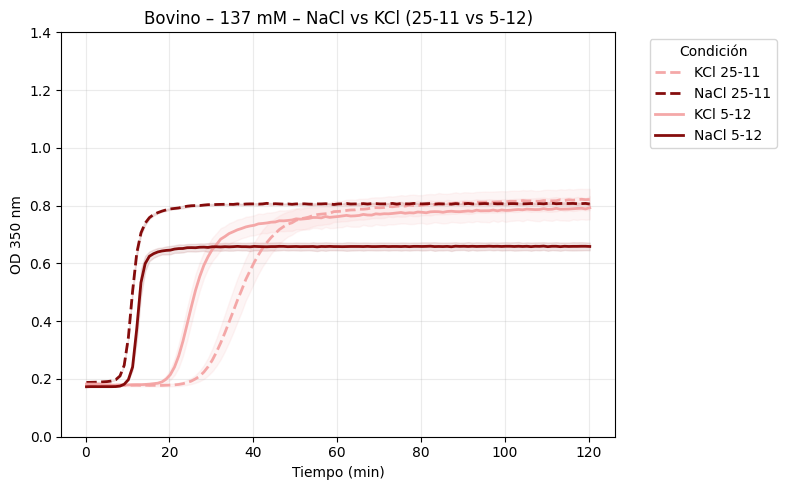

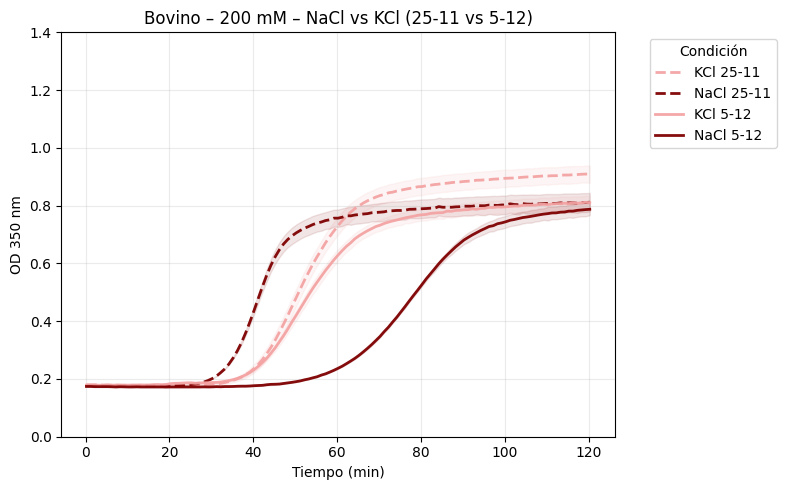

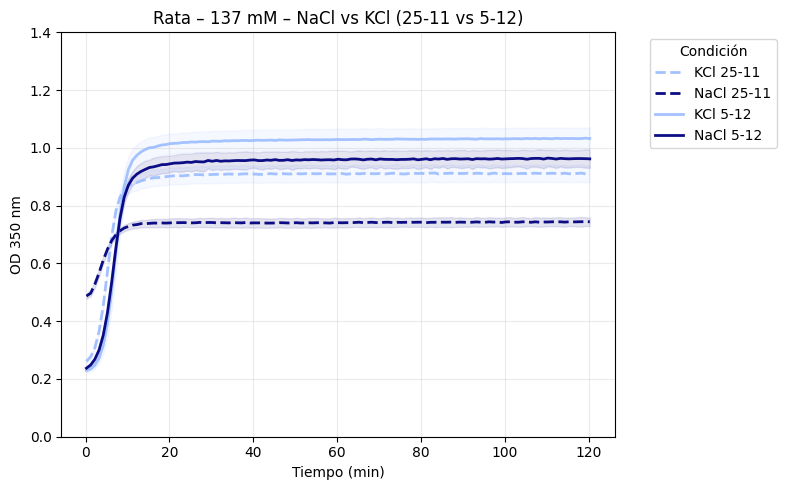

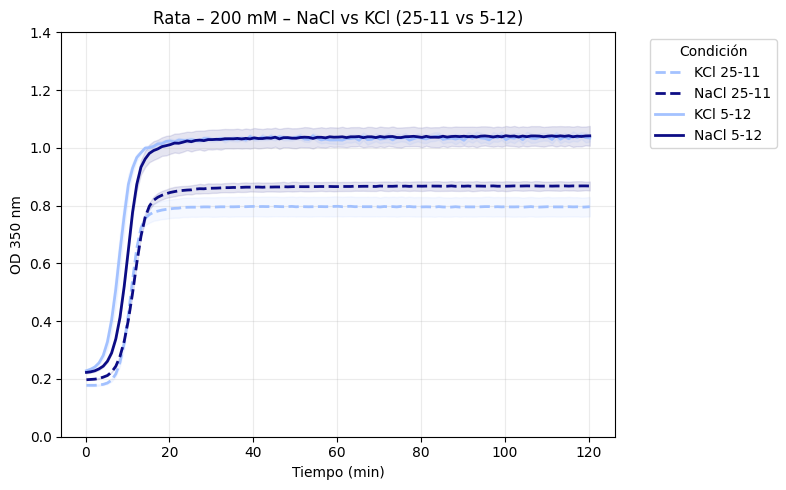

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# =============================
# Helper común: SEM
# =============================
def sem(x):
    return x.std(ddof=1) / np.sqrt(len(x))


# =========================================================
# 1. GRÁFICAS TIPO 1:
#    MISMA SAL (NaCl / KCl), 137 vs 200, COMPARANDO DÍAS
# =========================================================
def plot_species_conc_comparison(all_df, species, salt):
    """
    Una gráfica para:
      - especie concreta (Bovine / Rat)
      - UNA sal concreta (NaCl o KCl)
      - concentraciones 137 mM vs 200 mM

    REGLAS:
      - 137 mM → color más claro
      - 200 mM → color más intenso
      - 25-11 → línea discontinua
      - 5-12  → línea continua
      - Si salt == 'NaCl' y conc == '137 mM' → SOLO pH 6
    """

    sub = all_df[
        (all_df["species"] == species) &
        (all_df["salt"] == salt) &
        (all_df["conc"].isin(["137 mM", "200 mM"]))
    ].copy()

    # 🔴 filtro extra: NaCl 137 mM → solo pH 6
    if salt == "NaCl":
        sub = sub[~((sub["conc"] == "137 mM") & (sub["pH_group"] != "pH 6"))]

    if sub.empty:
        print("No hay datos para", species, salt, "en 137/200 mM (tras filtrar pH).")
        return

    stats = (
        sub
        .groupby(["time_min", "study", "conc"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
        .sort_values("time_min")
    )

    # Colores base por especie
    if species == "Bovine":
        base_light = "#f4a3a3"  # clarito
        base_dark  = "#7f0000"  # intenso
        especie_es = "Bovino"
    else:
        base_light = "#9fbfff"
        base_dark  = "#00007f"
        especie_es = "Rata"

    def color_from_conc(conc):
        return base_light if conc == "137 mM" else base_dark

    def ls_from_day(study):
        return "--" if study == "25-11" else "-"

    plt.figure(figsize=(8,5))

    for (study, conc), g in stats.groupby(["study", "conc"]):
        g = g.sort_values("time_min")

        color = color_from_conc(conc)
        ls    = ls_from_day(study)

        label = f"{conc} {study}"

        plt.plot(
            g["time_min"], g["mean"],
            color=color,
            linestyle=ls,
            linewidth=2,
            alpha=0.95,
            label=label
        )

        plt.fill_between(
            g["time_min"],
            g["mean"] - g["sem"],
            g["mean"] + g["sem"],
            color=color,
            alpha=0.10
        )

    titulo = f"{especie_es} – {salt} – 137 vs 200 mM (25-11 vs 5-12)"
    plt.title(titulo)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Condición")
    plt.tight_layout()
    plt.show()


# =========================================================
# 2. GRÁFICAS TIPO 2:
#    MISMA CONCENTRACIÓN (137 / 200),
#    NaCl vs KCl, COMPARANDO DÍAS
# =========================================================
def plot_species_salt_comparison(all_df, species, conc):
    """
    Una gráfica para:
      - especie concreta (Bovine / Rat)
      - UNA concentración (137 mM o 200 mM)
      - NaCl vs KCl

    REGLAS:
      - NaCl  → color más fuerte
      - KCl   → mismo tono más flojo
      - 25-11 → línea discontinua
      - 5-12  → línea continua
      - Si conc = '137 mM' → NaCl 137 mM SOLO pH 6
    """

    sub = all_df[
        (all_df["species"] == species) &
        (all_df["conc"] == conc) &
        (all_df["salt"].isin(["NaCl", "KCl"]))
    ].copy()

    # 🔴 filtro extra: si es 137 mM, NaCl solo pH 6
    if conc == "137 mM":
        sub = sub[~((sub["salt"] == "NaCl") & (sub["pH_group"] != "pH 6"))]

    if sub.empty:
        print("No hay datos para", species, "en", conc, "NaCl/KCl (tras filtrar pH).")
        return

    stats = (
        sub
        .groupby(["time_min", "study", "salt"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
        .sort_values("time_min")
    )

    # Colores por especie, NaCl fuerte / KCl flojo
    if species == "Bovine":
        nacl_strong = "#7f0000"
        kcl_weak    = "#f4a3a3"
        especie_es  = "Bovino"
    else:
        nacl_strong = "#00007f"
        kcl_weak    = "#9fbfff"
        especie_es  = "Rata"

    def color_from_salt(salt):
        return nacl_strong if salt == "NaCl" else kcl_weak

    def ls_from_day(study):
        return "--" if study == "25-11" else "-"

    plt.figure(figsize=(8,5))

    for (study, salt), g in stats.groupby(["study", "salt"]):
        g = g.sort_values("time_min")

        color = color_from_salt(salt)
        ls    = ls_from_day(study)

        label = f"{salt} {study}"

        plt.plot(
            g["time_min"], g["mean"],
            color=color,
            linestyle=ls,
            linewidth=2,
            alpha=0.95,
            label=label
        )

        plt.fill_between(
            g["time_min"],
            g["mean"] - g["sem"],
            g["mean"] + g["sem"],
            color=color,
            alpha=0.10
        )

    titulo = f"{especie_es} – {conc} – NaCl vs KCl (25-11 vs 5-12)"
    plt.title(titulo)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Condición")
    plt.tight_layout()
    plt.show()


# =========================================================
# 3. LLAMADAS → LAS 8 GRÁFICAS
# =========================================================

# --- BOVINO: concentración 137 vs 200 para NaCl y KCl ---
plot_species_conc_comparison(all_df, species="Bovine", salt="NaCl")
plot_species_conc_comparison(all_df, species="Bovine", salt="KCl")

# --- RATA: concentración 137 vs 200 para NaCl y KCl ---
plot_species_conc_comparison(all_df, species="Rat", salt="NaCl")
plot_species_conc_comparison(all_df, species="Rat", salt="KCl")

# --- BOVINO: NaCl vs KCl para 137 y 200 ---
plot_species_salt_comparison(all_df, species="Bovine", conc="137 mM")
plot_species_salt_comparison(all_df, species="Bovine", conc="200 mM")

# --- RATA: NaCl vs KCl para 137 y 200 ---
plot_species_salt_comparison(all_df, species="Rat", conc="137 mM")
plot_species_salt_comparison(all_df, species="Rat", conc="200 mM")
